In [1]:
import deepchem as dc
import pandas as pd
import numpy as np

import xgboost as xgb
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import ast
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

from sklearn.preprocessing import LabelEncoder

Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
data = pd.read_csv('../../data/BST.csv',encoding = 'gb2312')

In [3]:
data

,Name,SMILES,Flavor type,Data resource,Label
0,549-56-4,COC1=CC2=C(C=CN=C2C=C1)C(C3CC4CCN3CC4C=C)O.OS(...,Bitter,NaN,[1]
1,NaN,COC1=CC2=C(C=CN=C2C=C1)C(C3CC4CC[NH+]3CC4C=C)O,Bitter,NaN,[1]
2,"469-02-3,54378-50-6,54378-86-8",CC(C)CC(=O)C1=C(C(C(=O)C(C1=O)CC=C(C)C)(CC=C(C...,Bitter,NaN,[1]
3,6119-70-6,COC1=CC2=C(C=CN=C2C=C1)C(C3CC4CCN3CC4C=C)O.COC...,Bitter,NaN,[1]
4,100-52-7,C1=CC=C(C=C1)C=O,Bitter,NaN,[1]
...,...,...,...,...,...
15215,CNP0005404,O=C1N(CC2=NC=CC=C2)CC3N1CCN(CC=4C=CC=CC4)C3,Tasteless,Coconut,[3]
15216,CNP0005405,O=C1N(CC=2C=NC=CC2)CC3N1CCN(C3)C4CCOCC4,Tasteless,Coconut,[3]
15217,CNP0005406,O=C1N(C=2C=CC=CC2)CC3N1CCN(C3)C4CCN(C(=O)C)CC4,Tasteless,Coconut,[3]
15218,CNP0005407,O=C1N(C=2C=CC=CC2)CC3N1CCN(CC4=NC=CC=C4)C3,Tasteless,Coconut,[3]


# 特征提取

In [4]:
featurizer = dc.feat.MACCSKeysFingerprint()
features = featurizer.featurize(data['SMILES'])
#dataset = dc.data.NumpyDataset(features,data['Label'])

[15:58:09] WARNING: not removing hydrogen atom without neighbors


In [5]:
from sklearn.feature_selection import VarianceThreshold

# 初始化VarianceThreshold对象
vt = VarianceThreshold(threshold = (.98 * (1 - .98)))

# 进行特征选择
X_new = vt.fit_transform(features)
dataset = dc.data.NumpyDataset(X_new,data['Label'],ids=data['SMILES'])

## 数据划分

In [6]:
splitter = dc.splits.RandomSplitter()
train_dataset,test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=300)

# Multi-label

In [7]:
train_dataset_y = [ast.literal_eval(label) for label in train_dataset.y]
test_dataset_y  = [ast.literal_eval(label) for label in test_dataset.y]
train_new_y = MultiLabelBinarizer().fit_transform(train_dataset_y)
test_new_y = MultiLabelBinarizer().fit_transform(test_dataset_y)

# Data distribution ratio

In [8]:
def row_counter(my_array):
    list_of_tups = [tuple(ele) for ele in my_array]
    return Counter(list_of_tups)

In [9]:
print('train_dataset:',row_counter(train_new_y))
train_counter = row_counter(train_new_y)
print('Bitter : Sweet : Tasteless = ',train_counter[(1, 0, 0)]/10420,':',train_counter[(0, 1, 0)]/10420,':',train_counter[(0, 0, 1)]/10420)
print('test_dataset:',row_counter(test_new_y))
test_counter = row_counter(test_new_y)
print('Bitter : Sweet : Tasteless = ',test_counter[(1, 0, 0)]/2606,':',test_counter[(0, 1, 0)]/2606,':',test_counter[(0, 0, 1)]/2606)

train_dataset: Counter({(0, 1, 0): 4934, (0, 0, 1): 3976, (1, 0, 0): 3266})
Bitter : Sweet : Tasteless =  0.3134357005758157 : 0.47351247600767754 : 0.38157389635316696
test_dataset: Counter({(0, 1, 0): 1165, (0, 0, 1): 1005, (1, 0, 0): 874})
Bitter : Sweet : Tasteless =  0.3353798925556408 : 0.44704528012279354 : 0.3856485034535687


# GridSearchCV

In [10]:
scoring = {
     'F1_score': make_scorer(f1_score,average ='macro'),
     'Accuracy': make_scorer(accuracy_score),
     'Recall': make_scorer(recall_score,average = 'macro'),
     'Precision':make_scorer(precision_score,average = 'macro'),
}

param_grid = {'estimator__n_estimators':[200],
                  'estimator__max_depth':[15,17,19,21,23],
                  'estimator__colsample_bytree':[0.3,0.5,0.7,0.9],
                 'estimator__learning_rate':[0.01,0.05, 0.1,0.15,0.2]
                 }

In [ ]:
classifier = xgb.XGBClassifier()
ovr = OneVsRestClassifier(classifier)

gs = GridSearchCV(
                    ovr,
                    param_grid,
                    scoring = scoring,
                    cv = KFold(n_splits=5, shuffle=True, random_state=300),
                    n_jobs = -1,
                    refit = 'F1_score',
                    return_train_score = True)

gs_fit = gs.fit(train_dataset.X,train_new_y)

In [ ]:
val_F1 = gs.best_score_
val_ACC = gs.cv_results_['mean_test_Accuracy'][gs.best_index_]
val_Recall = gs.cv_results_['mean_test_Recall'][gs.best_index_]
val_Precision = gs.cv_results_['mean_test_Precision'][gs.best_index_]

In [13]:
print('Best parameters: ', gs.best_params_)
print('Best score (F1): ', val_F1)
print('Accuracy:',val_ACC)
print('Recall:',val_Recall)
print('Precision:',val_Precision)

Best parameters:  {'estimator__colsample_bytree': 0.3, 'estimator__learning_rate': 0.15, 'estimator__max_depth': 23, 'estimator__n_estimators': 200}
Best score (F1):  0.864040808254048
Accuracy: 0.868426103646833
Recall: 0.8441679169616639
Precision: 0.8866815547858297


In [14]:
model_multi = gs_fit.best_estimator_
model_multi

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.15, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=23,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))

# Evaluate model

In [15]:
y_test_pred = model_multi.predict(test_dataset.X)
y_test_pred

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]])

In [16]:
# 将真实标签和预测标签转换为整数形式
y_true = np.argmax(test_new_y, axis=1)
y_pred = np.argmax(y_test_pred, axis=1)

In [17]:
# 将标签转换为整数形式
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(y_true)
y_pred = label_encoder.transform(y_pred)

In [18]:
cm = confusion_matrix(y_true, y_pred)

In [19]:
cm

array([[ 356,   17,   40],
       [  40, 1116,   43],
       [ 104,   72,  818]], dtype=int64)

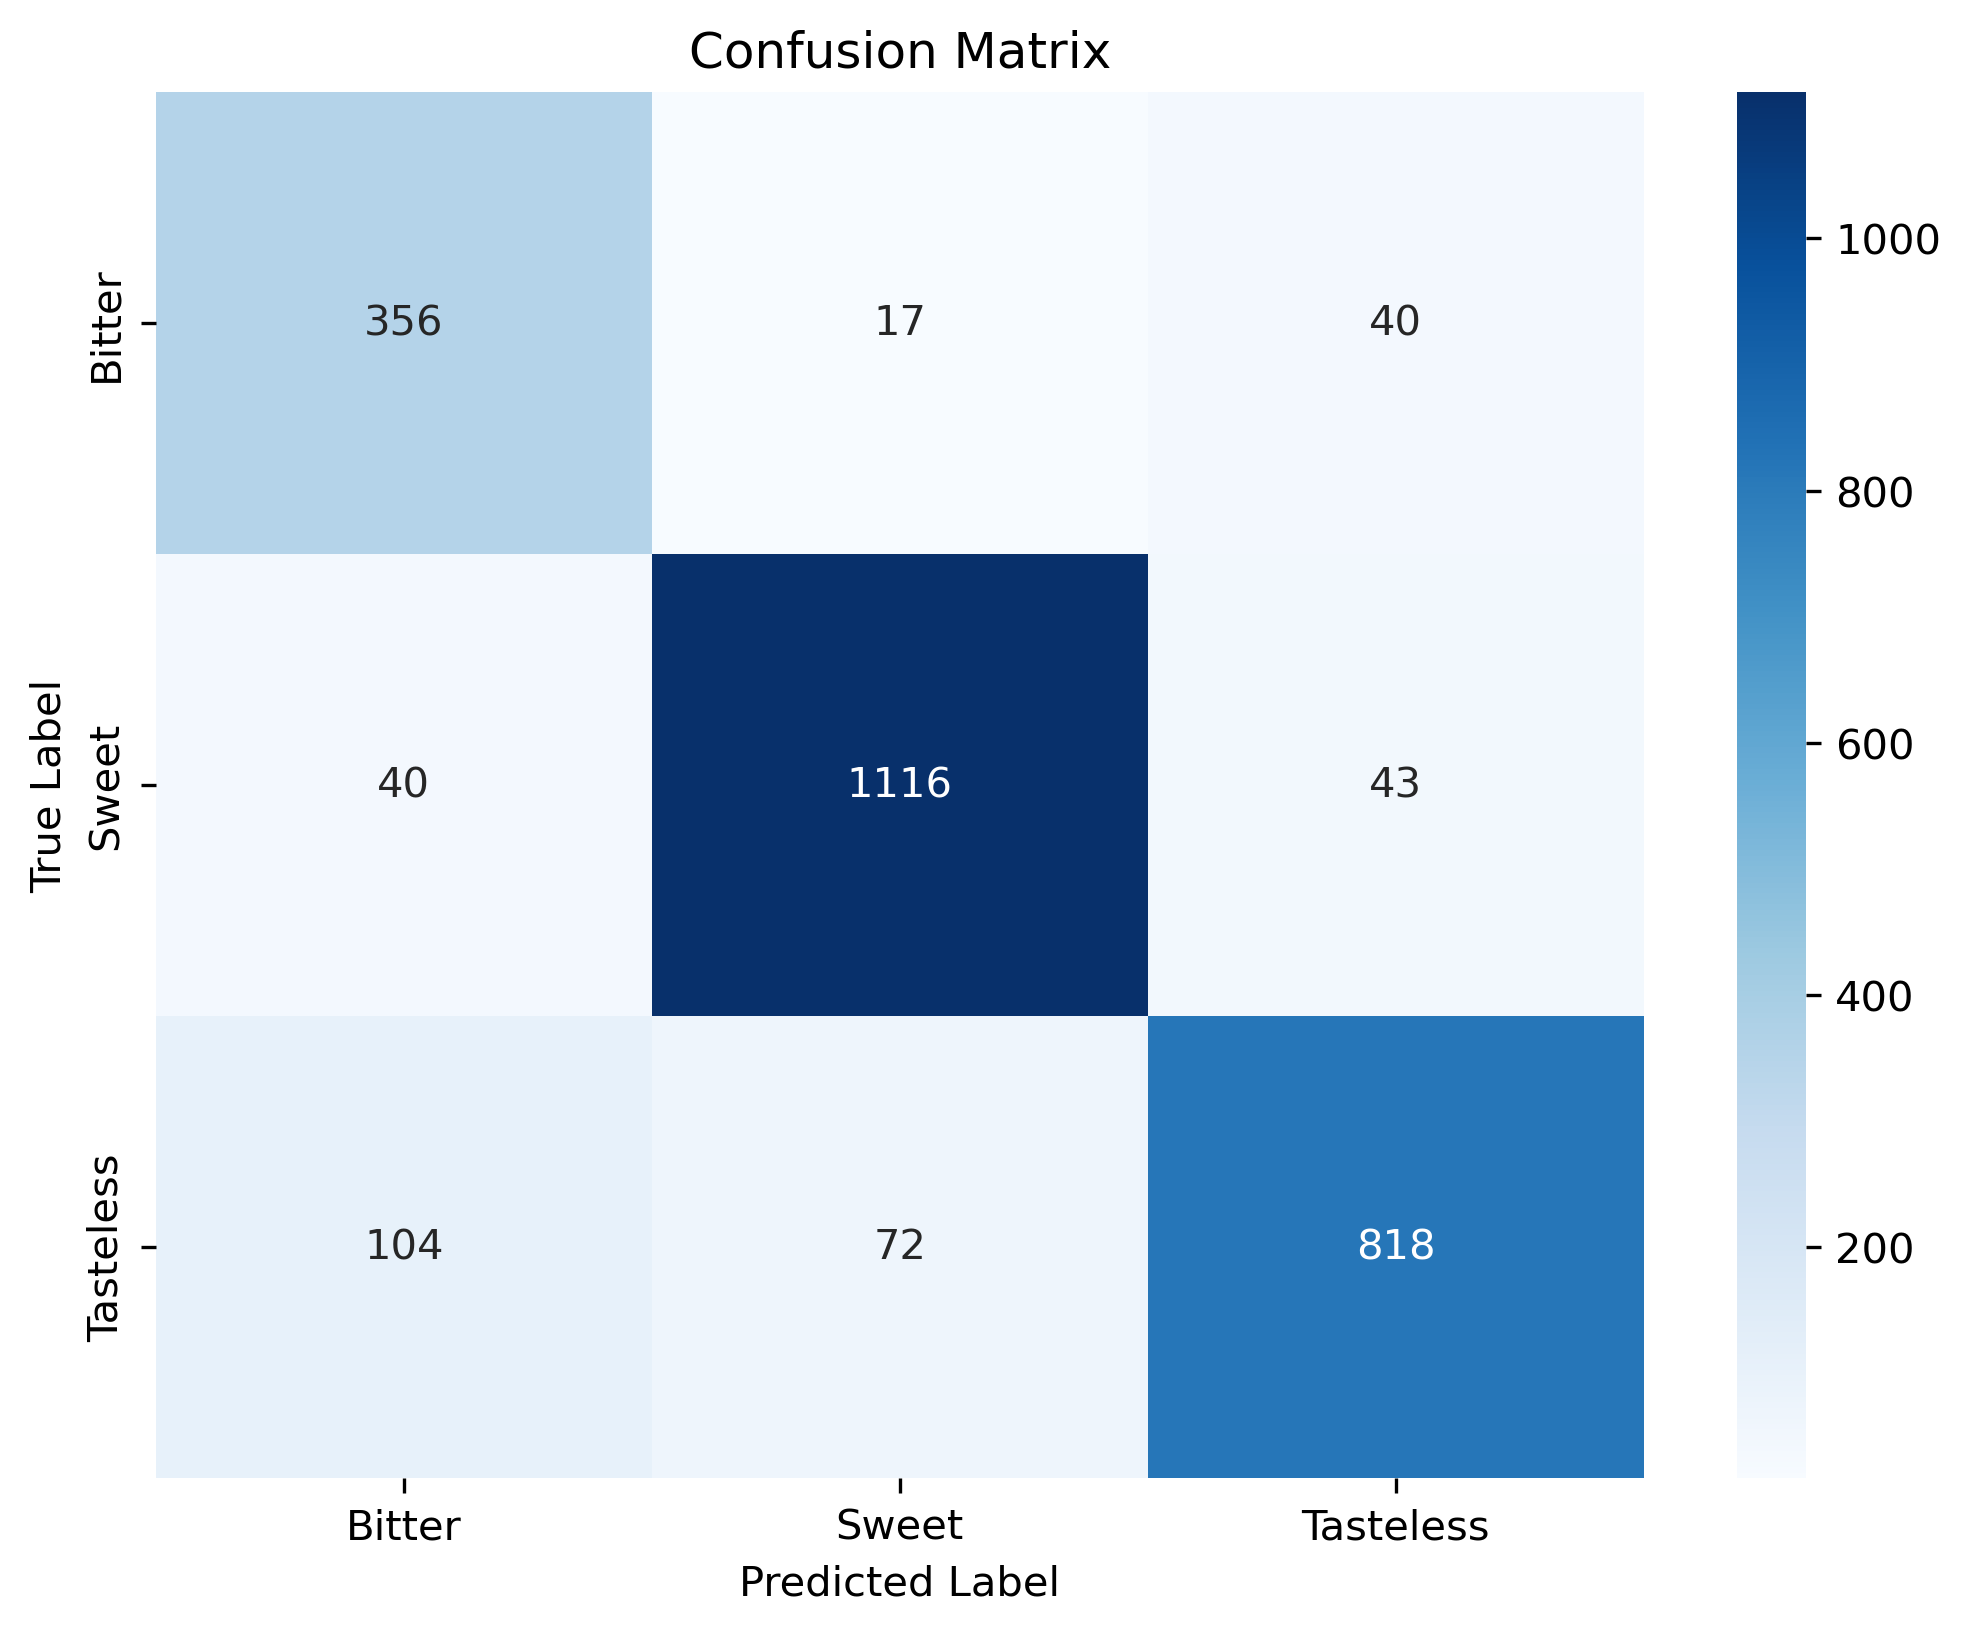

In [20]:
class_names = label_encoder.classes_  # 类别名称

# 绘制混淆矩阵图
class_names = ['Bitter', 'Sweet', 'Tasteless']  # 类别名称

# 标准化混淆矩阵
#cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [21]:
test_F1 = f1_score(test_new_y, y_test_pred,average ='macro')
test_ACC = accuracy_score(test_new_y, y_test_pred)
test_Recall = recall_score(test_new_y,y_test_pred,average = 'macro')
test_Precision = precision_score(test_new_y, y_test_pred,average = 'macro')

In [22]:
rf_performance_dataset = {
    'F1_score':[val_F1,test_F1],
    'ACC':[val_ACC,test_ACC],
    'Recall':[val_Recall,test_Recall],
    'Precision':[val_Precision,test_Precision],
}

In [23]:
rf_performance = pd.DataFrame(rf_performance_dataset,index=['val','test'])
rf_performance

,F1_score,ACC,Recall,Precision
val,0.864041,0.868426,0.844168,0.886682
test,0.866816,0.861474,0.844856,0.890827


In [24]:
import pickle

# 假设您的模型保存在变量 model 中
with open('xgb_maccs_model.pkl', 'wb') as f:
    pickle.dump(model_multi, f)

# SHAP

In [3]:
import pickle
import shap
shap.initjs()

In [5]:
with open('../xgb_maccs_model.pkl', 'rb') as f:
    xgb_maccs_model = pickle.load(f)

In [42]:
K = 100
background_summary = shap.sample(train_dataset.X, 100)

In [43]:
explainer = shap.KernelExplainer(xgb_maccs_model.predict,background_summary)

In [44]:
shap_values = explainer.shap_values(test_dataset.X)

100%|██████████████████████████████████████████████████████████████████████████████| 2606/2606 [58:45<00:00,  1.35s/it]


In [85]:
import matplotlib.colors as mcolors 
color = mcolors.ListedColormap(['#2878B5','#9AC9DB', '#F8AC8C'])
class_names = ['bitter', 'sweet','tasteless']

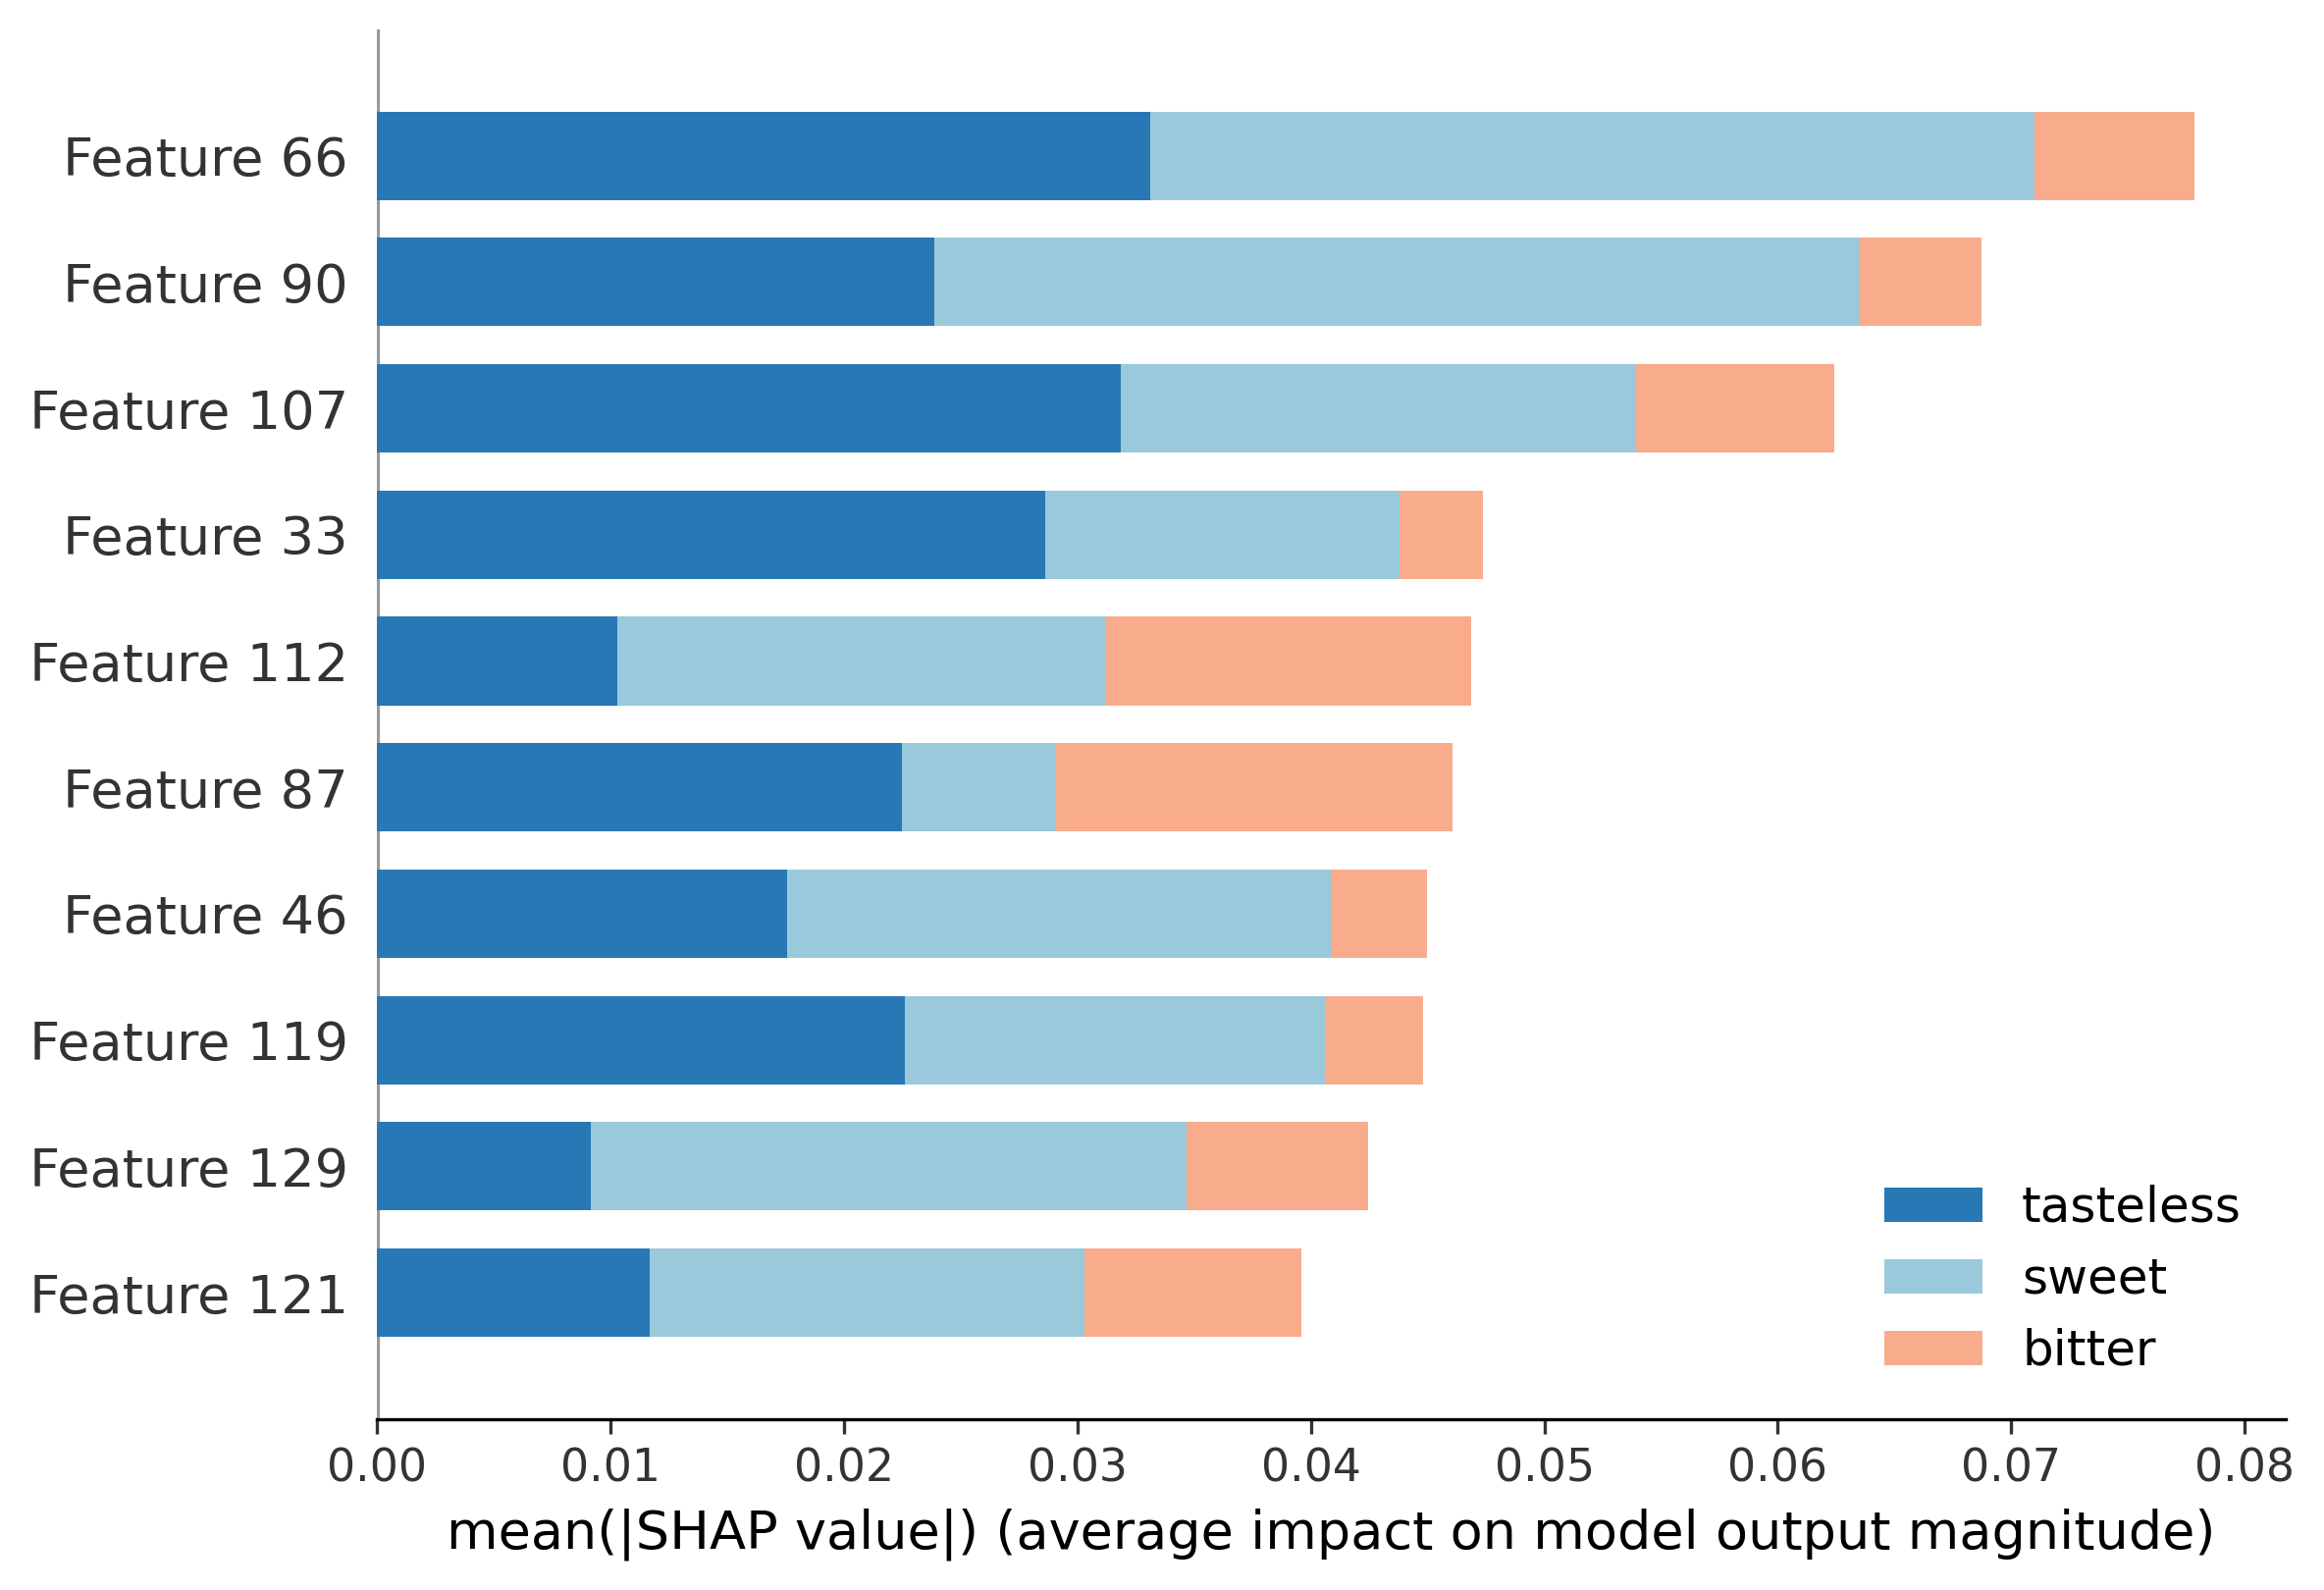

In [86]:
shap.summary_plot(shap_values[0:3], test_dataset.X, plot_type='bar', max_display=10,  class_names=class_names, color=color)

In [50]:
data_maccs_mask = vt.get_support(indices=True)

In [51]:
data_maccs_mask

array([ 11,  19,  22,  24,  26,  29,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  42,  43,  44,  48,  49,  50,  51,  52,  53,  54,  55,
        57,  58,  59,  60,  61,  62,  64,  65,  66,  67,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166], dtype=int64)

In [52]:
MACCS = pd.read_csv('../../data/MACCS.csv', encoding='gb18030')

In [53]:
result = [MACCS['REMARK'][i-1] for i in data_maccs_mask]

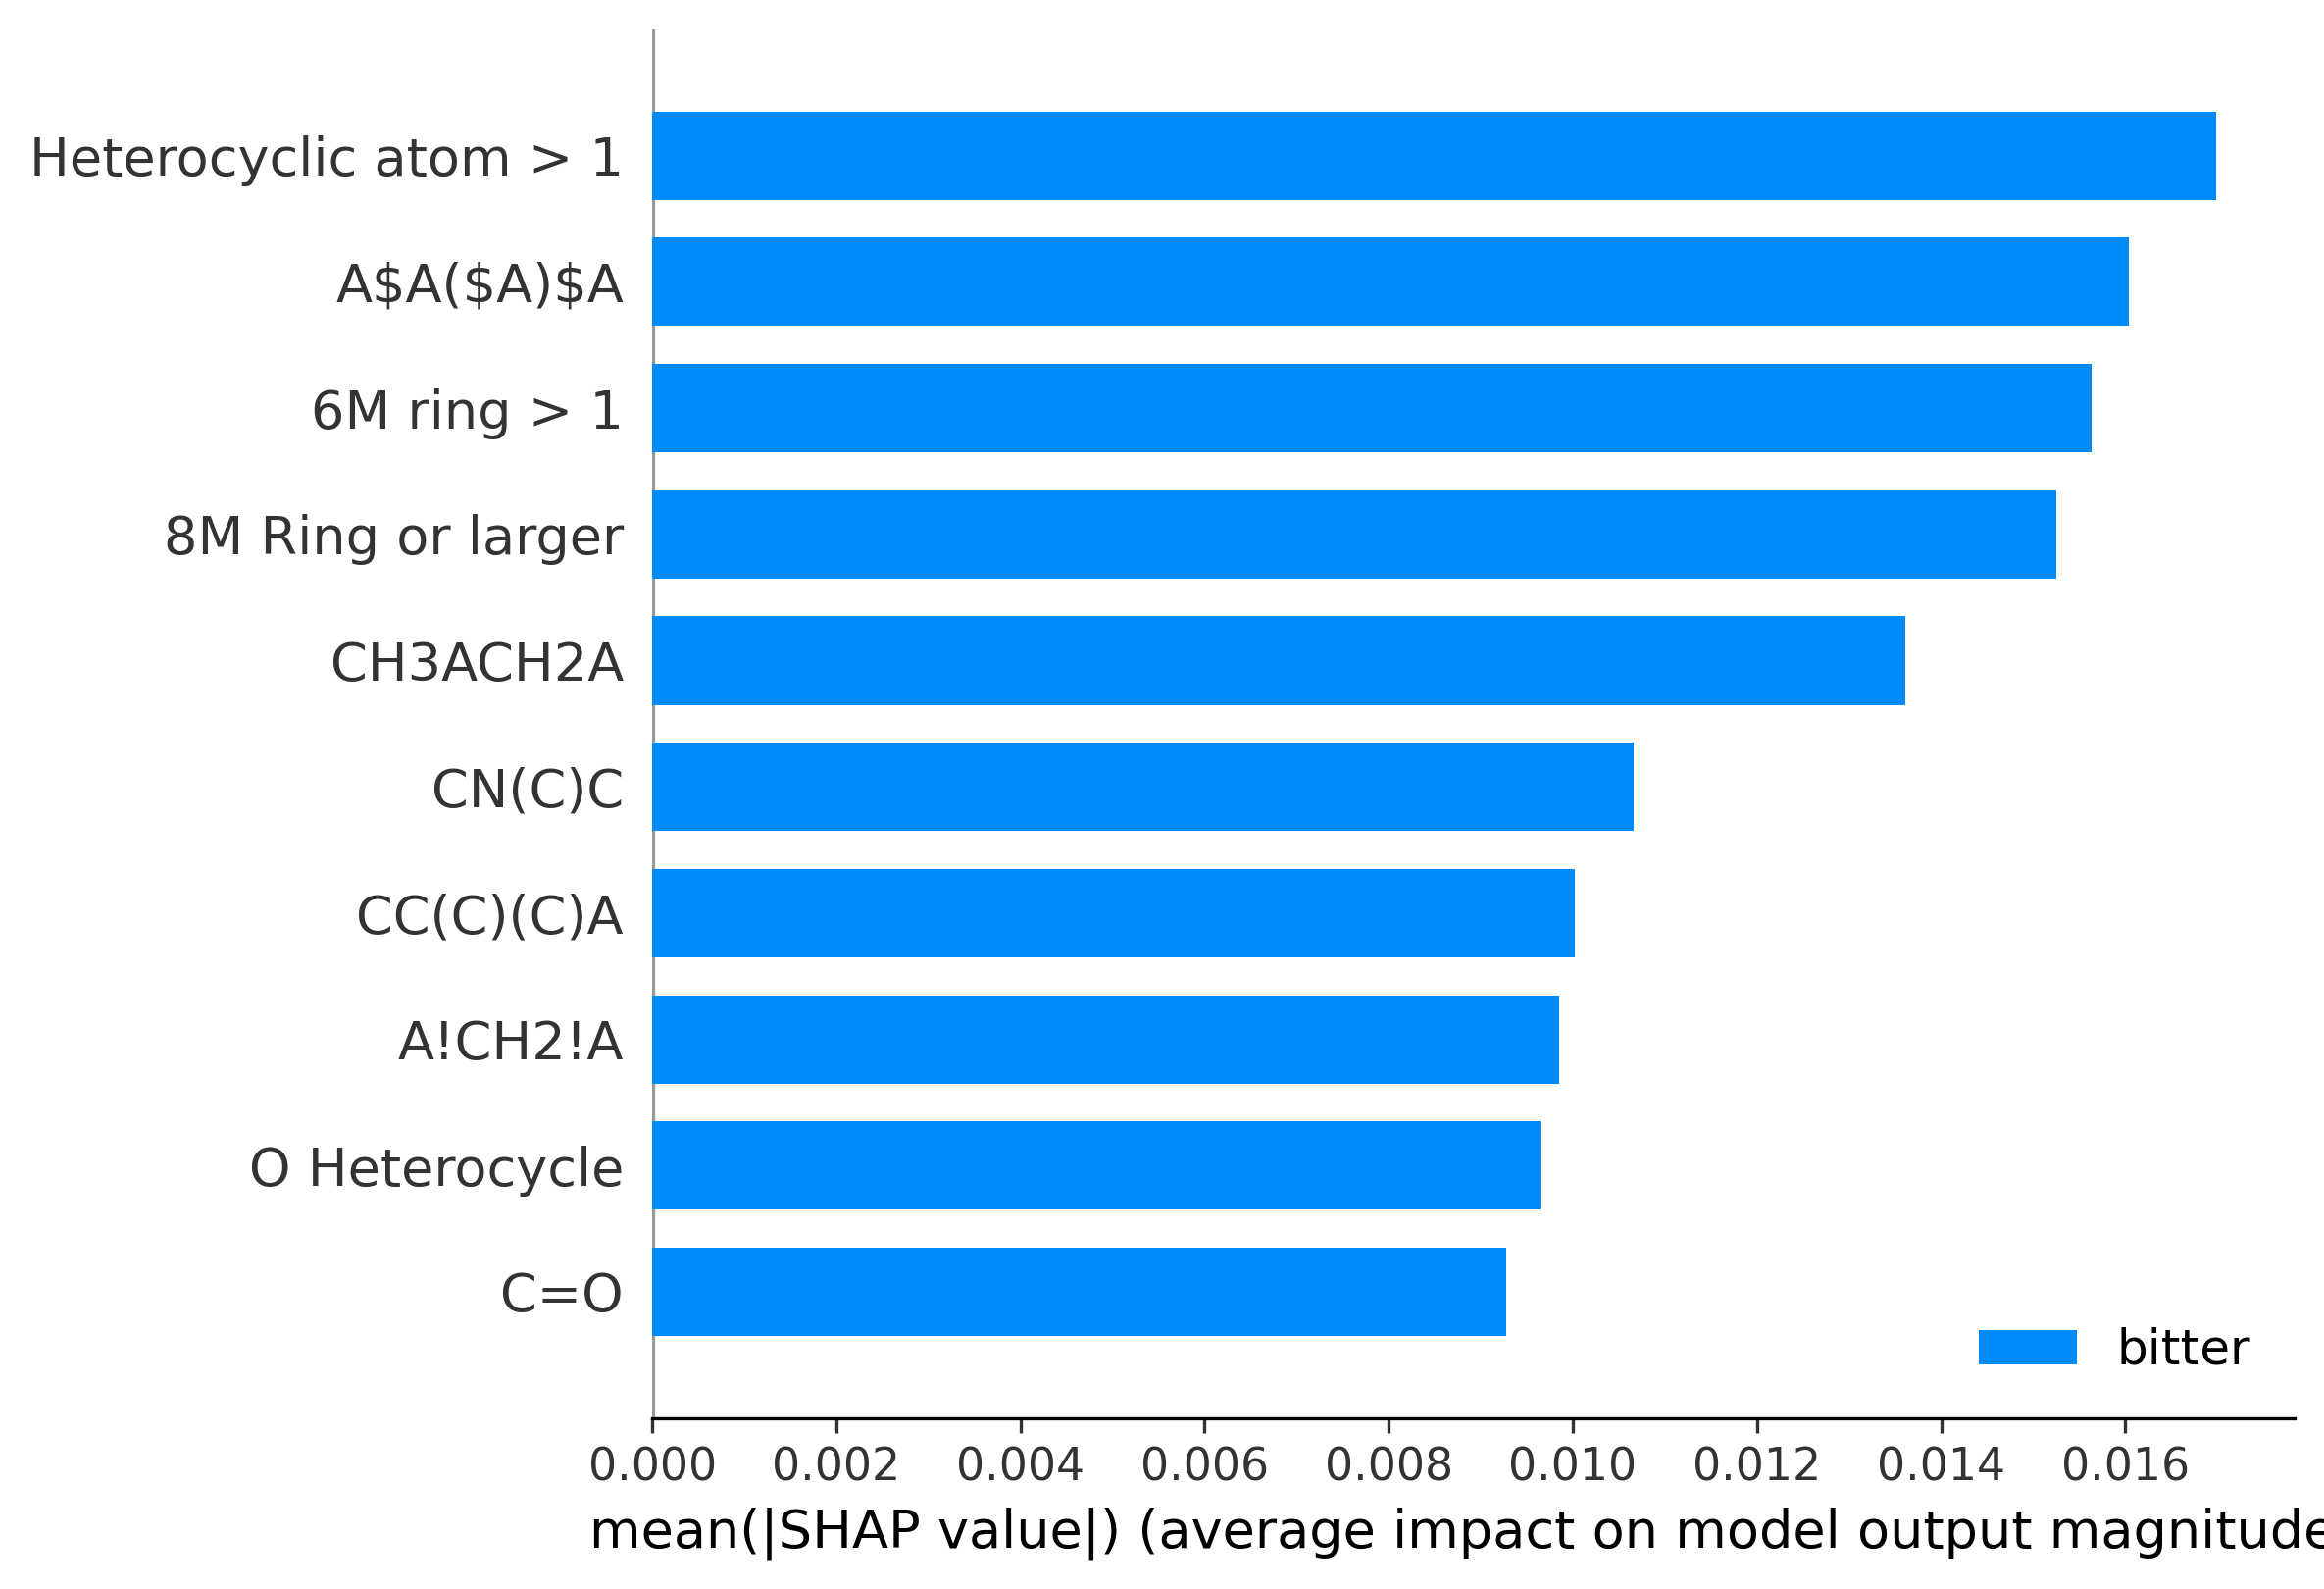

In [96]:
shap.summary_plot(shap_values[0:1], test_dataset.X, plot_type='bar', max_display=10,  class_names = ['bitter'], feature_names = result)

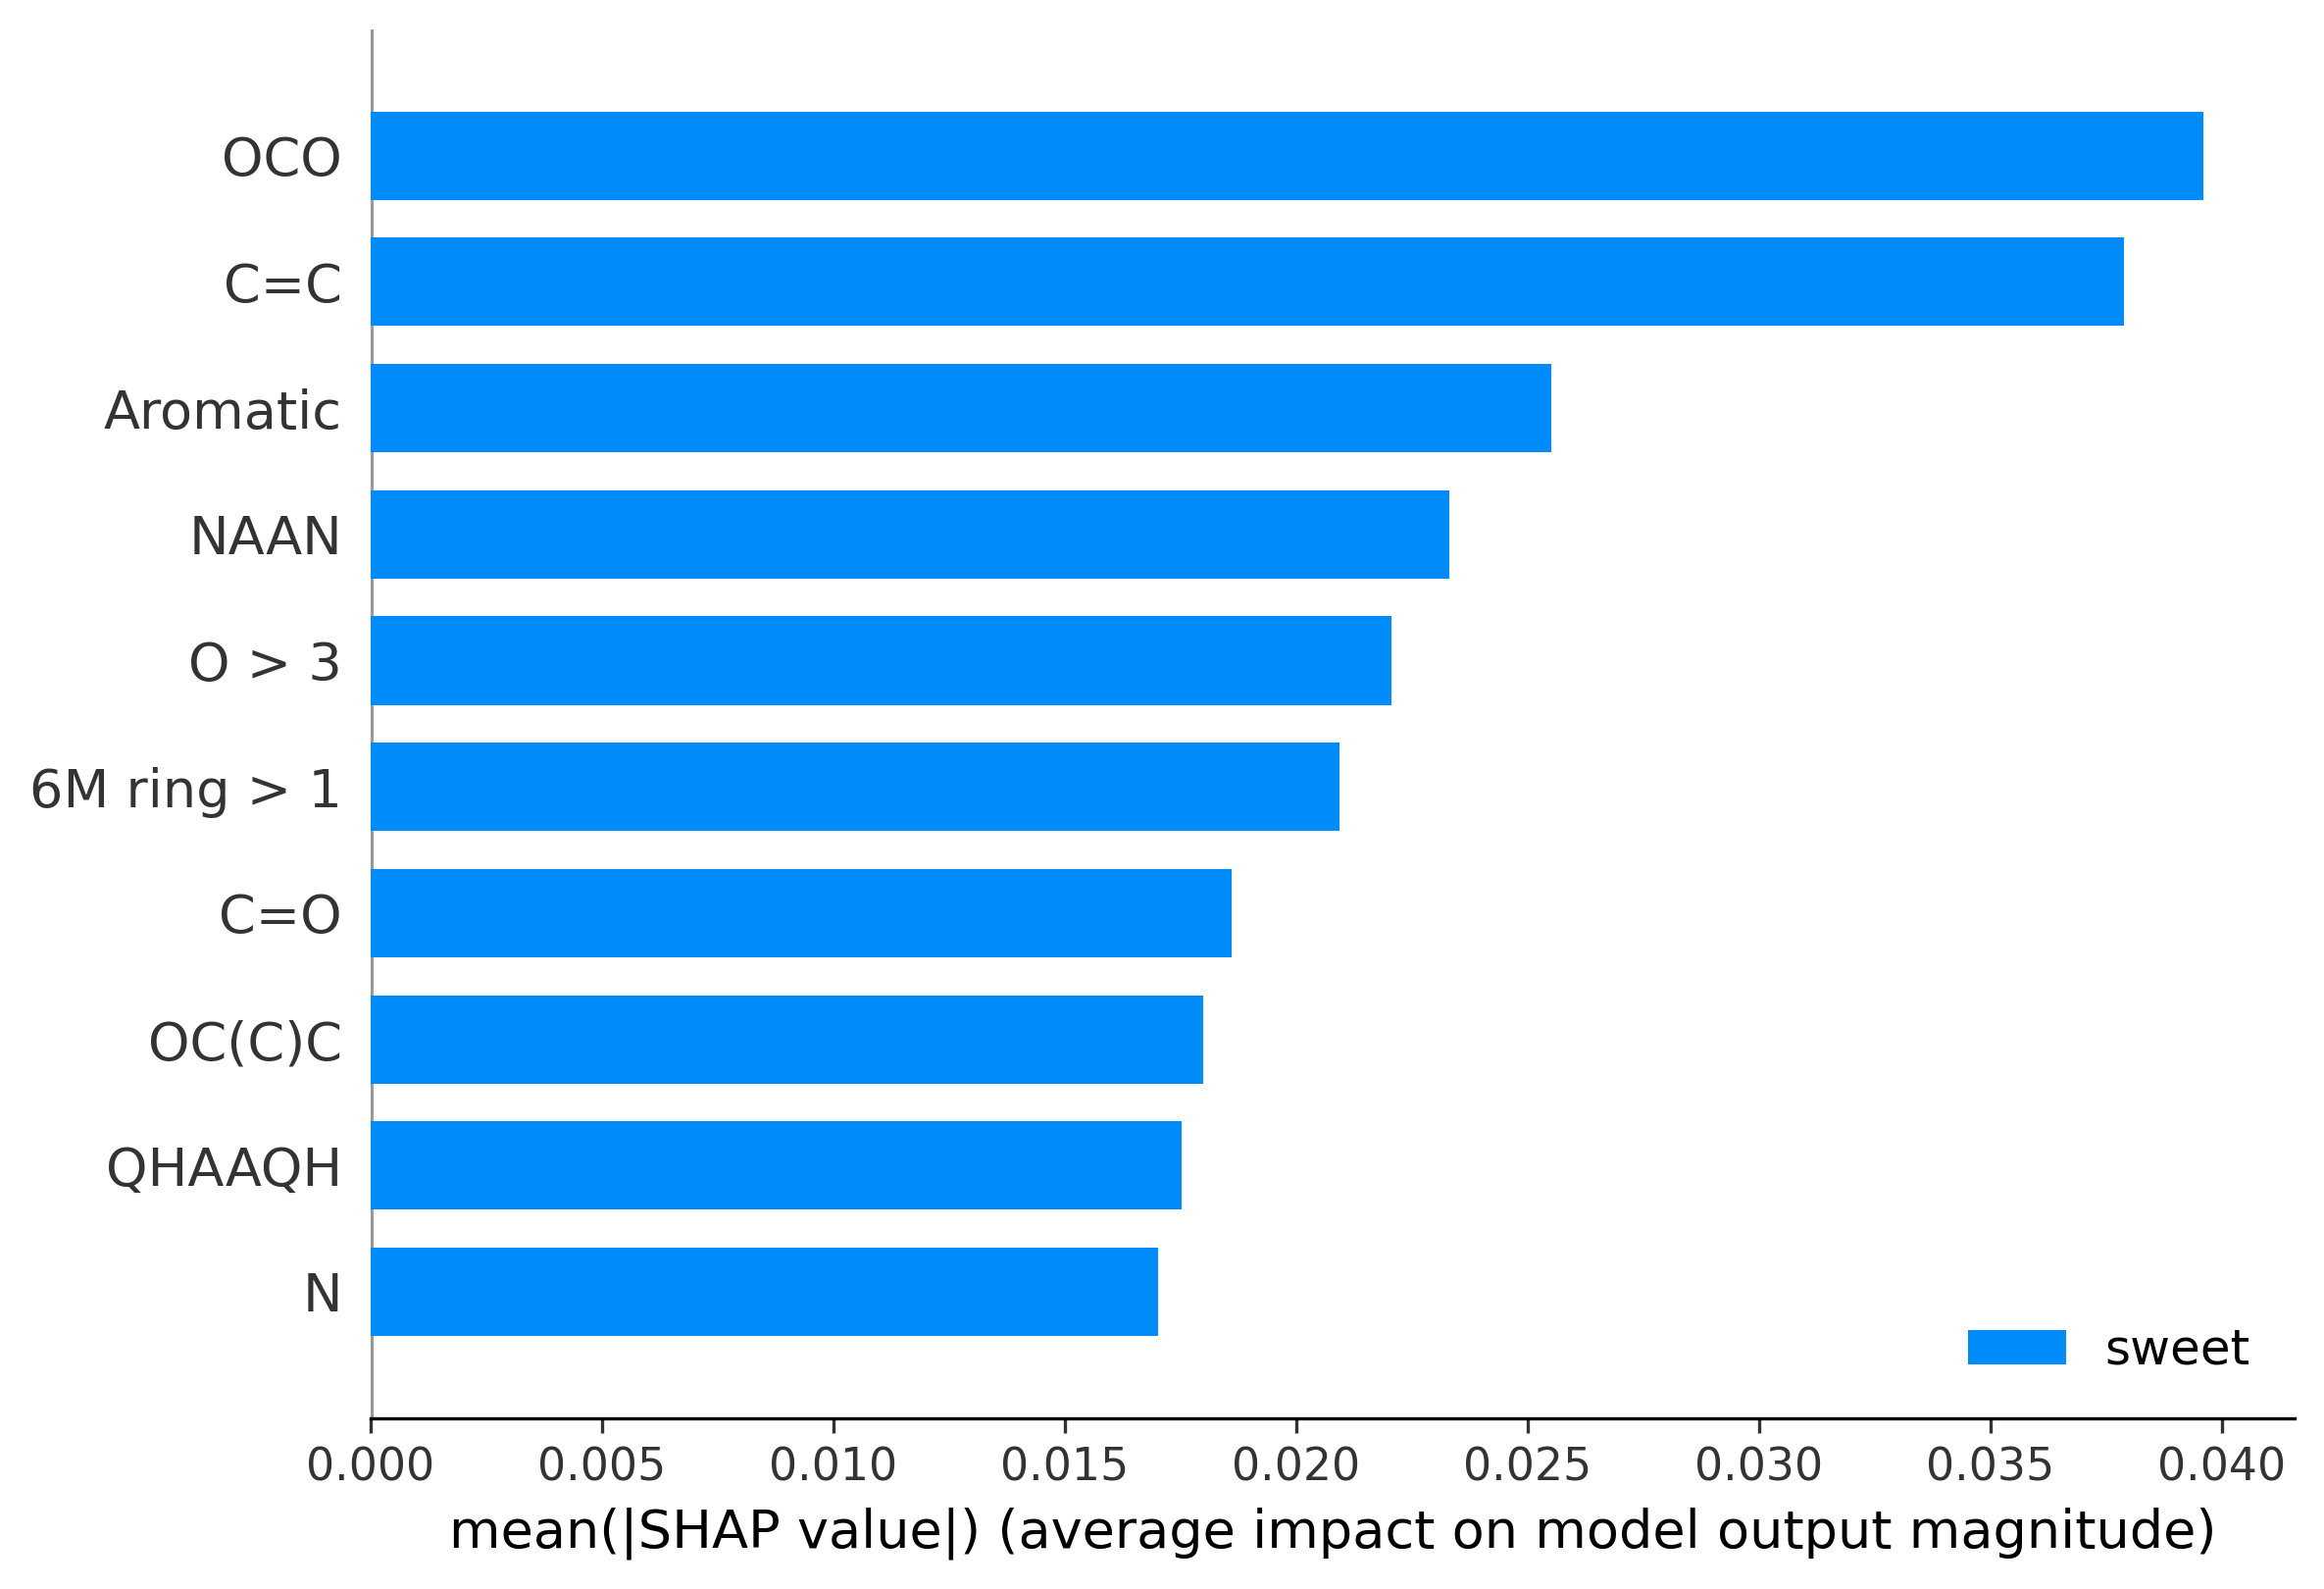

In [97]:
shap.summary_plot(shap_values[1:2], test_dataset.X, plot_type='bar', max_display=10,class_names = ['sweet'],feature_names = result)

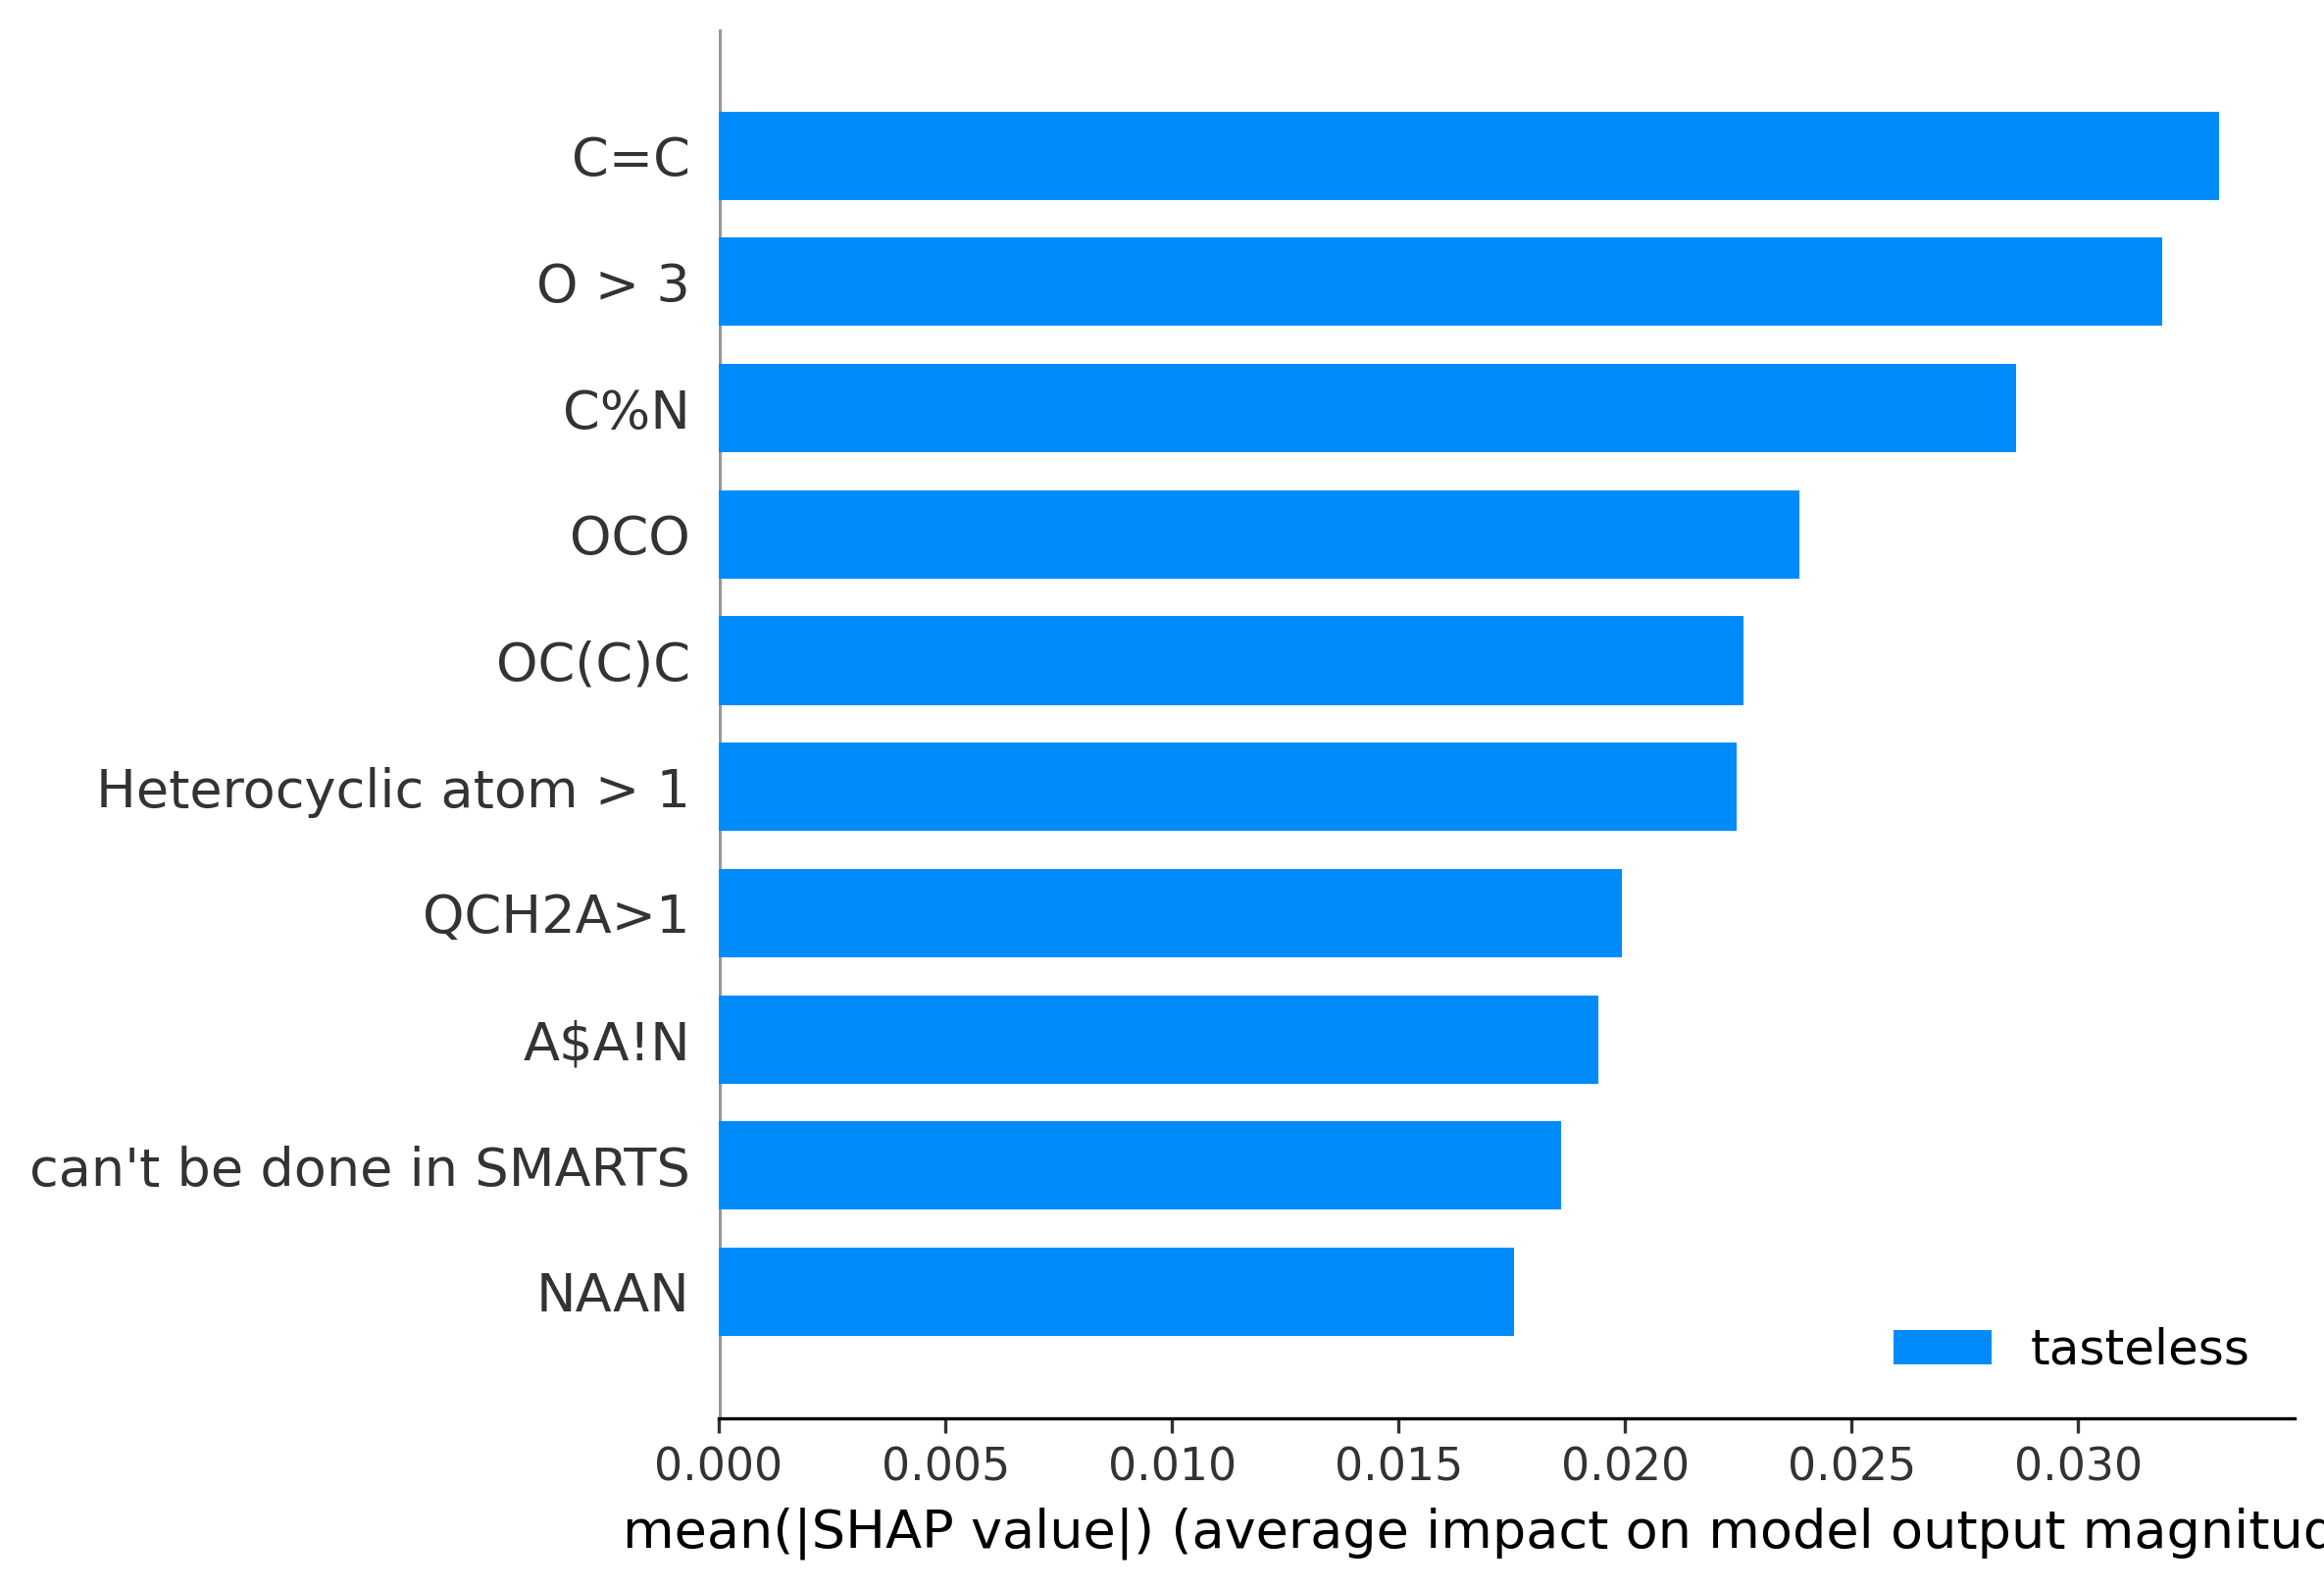

In [98]:
shap.summary_plot(shap_values[2:3], test_dataset.X, plot_type='bar', max_display=10, class_names = ['tasteless'], feature_names = result)

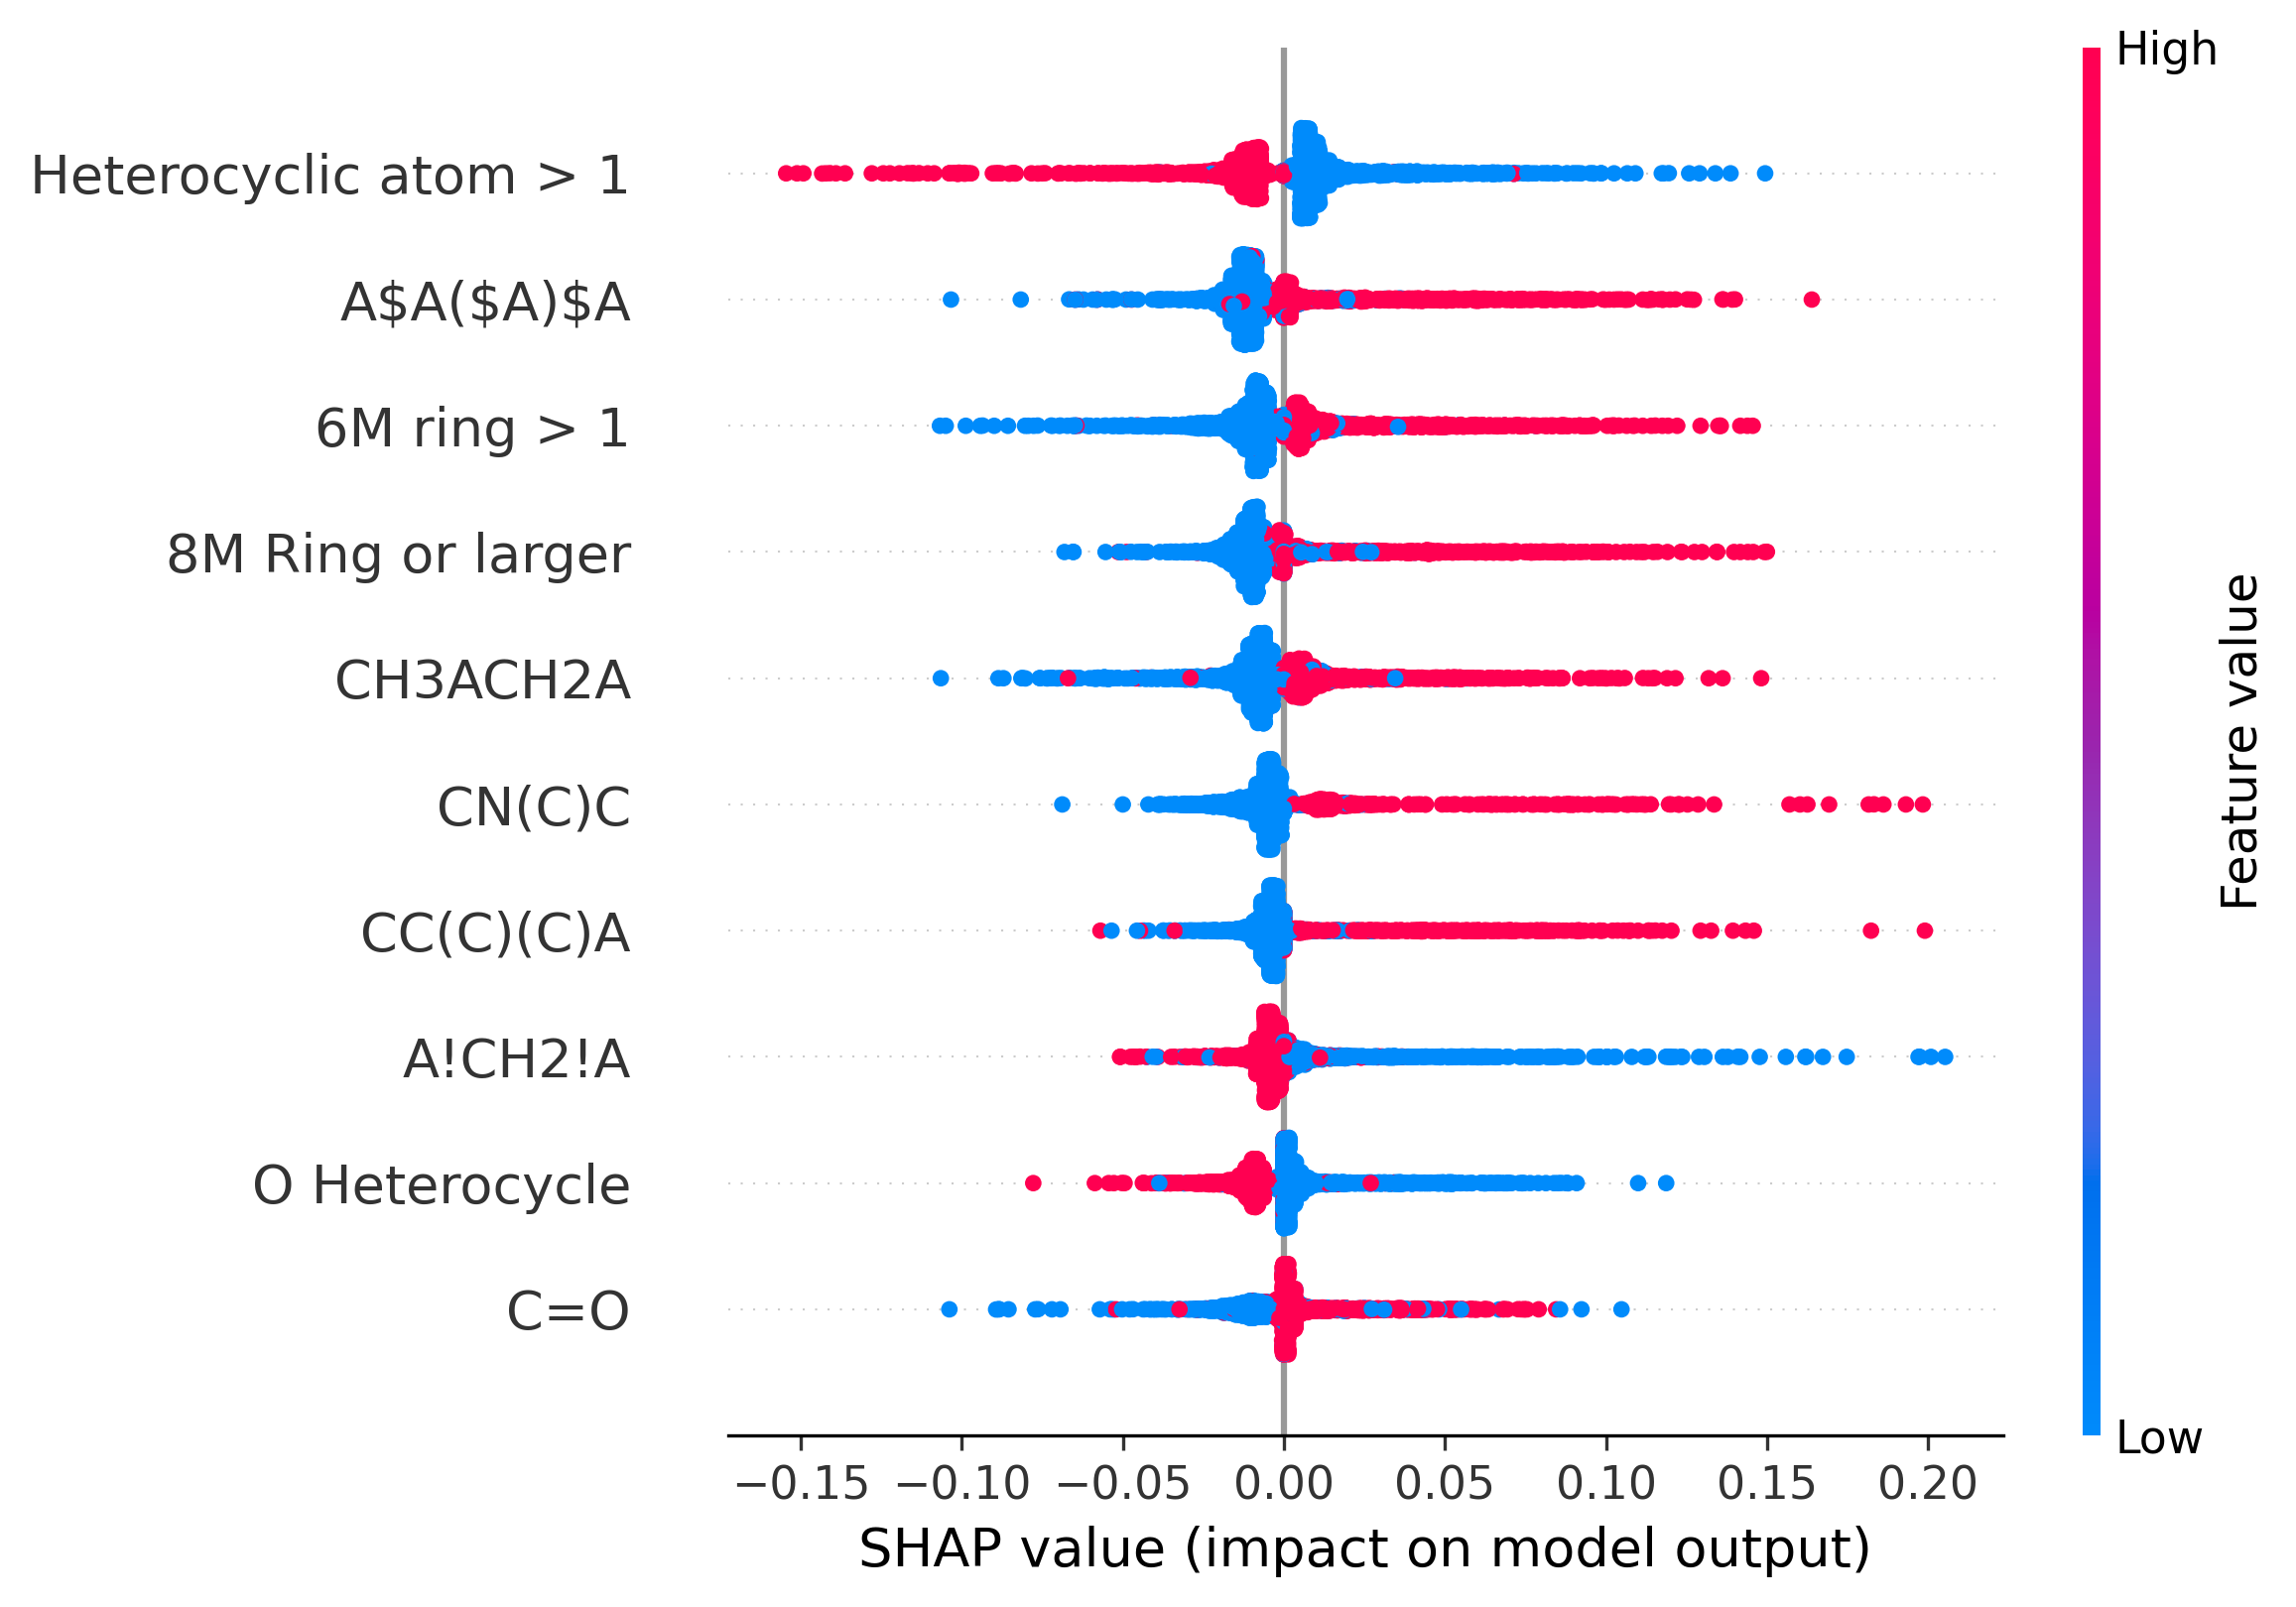

In [99]:
shap.summary_plot(shap_values[0], test_dataset.X, max_display=10, feature_names = result)

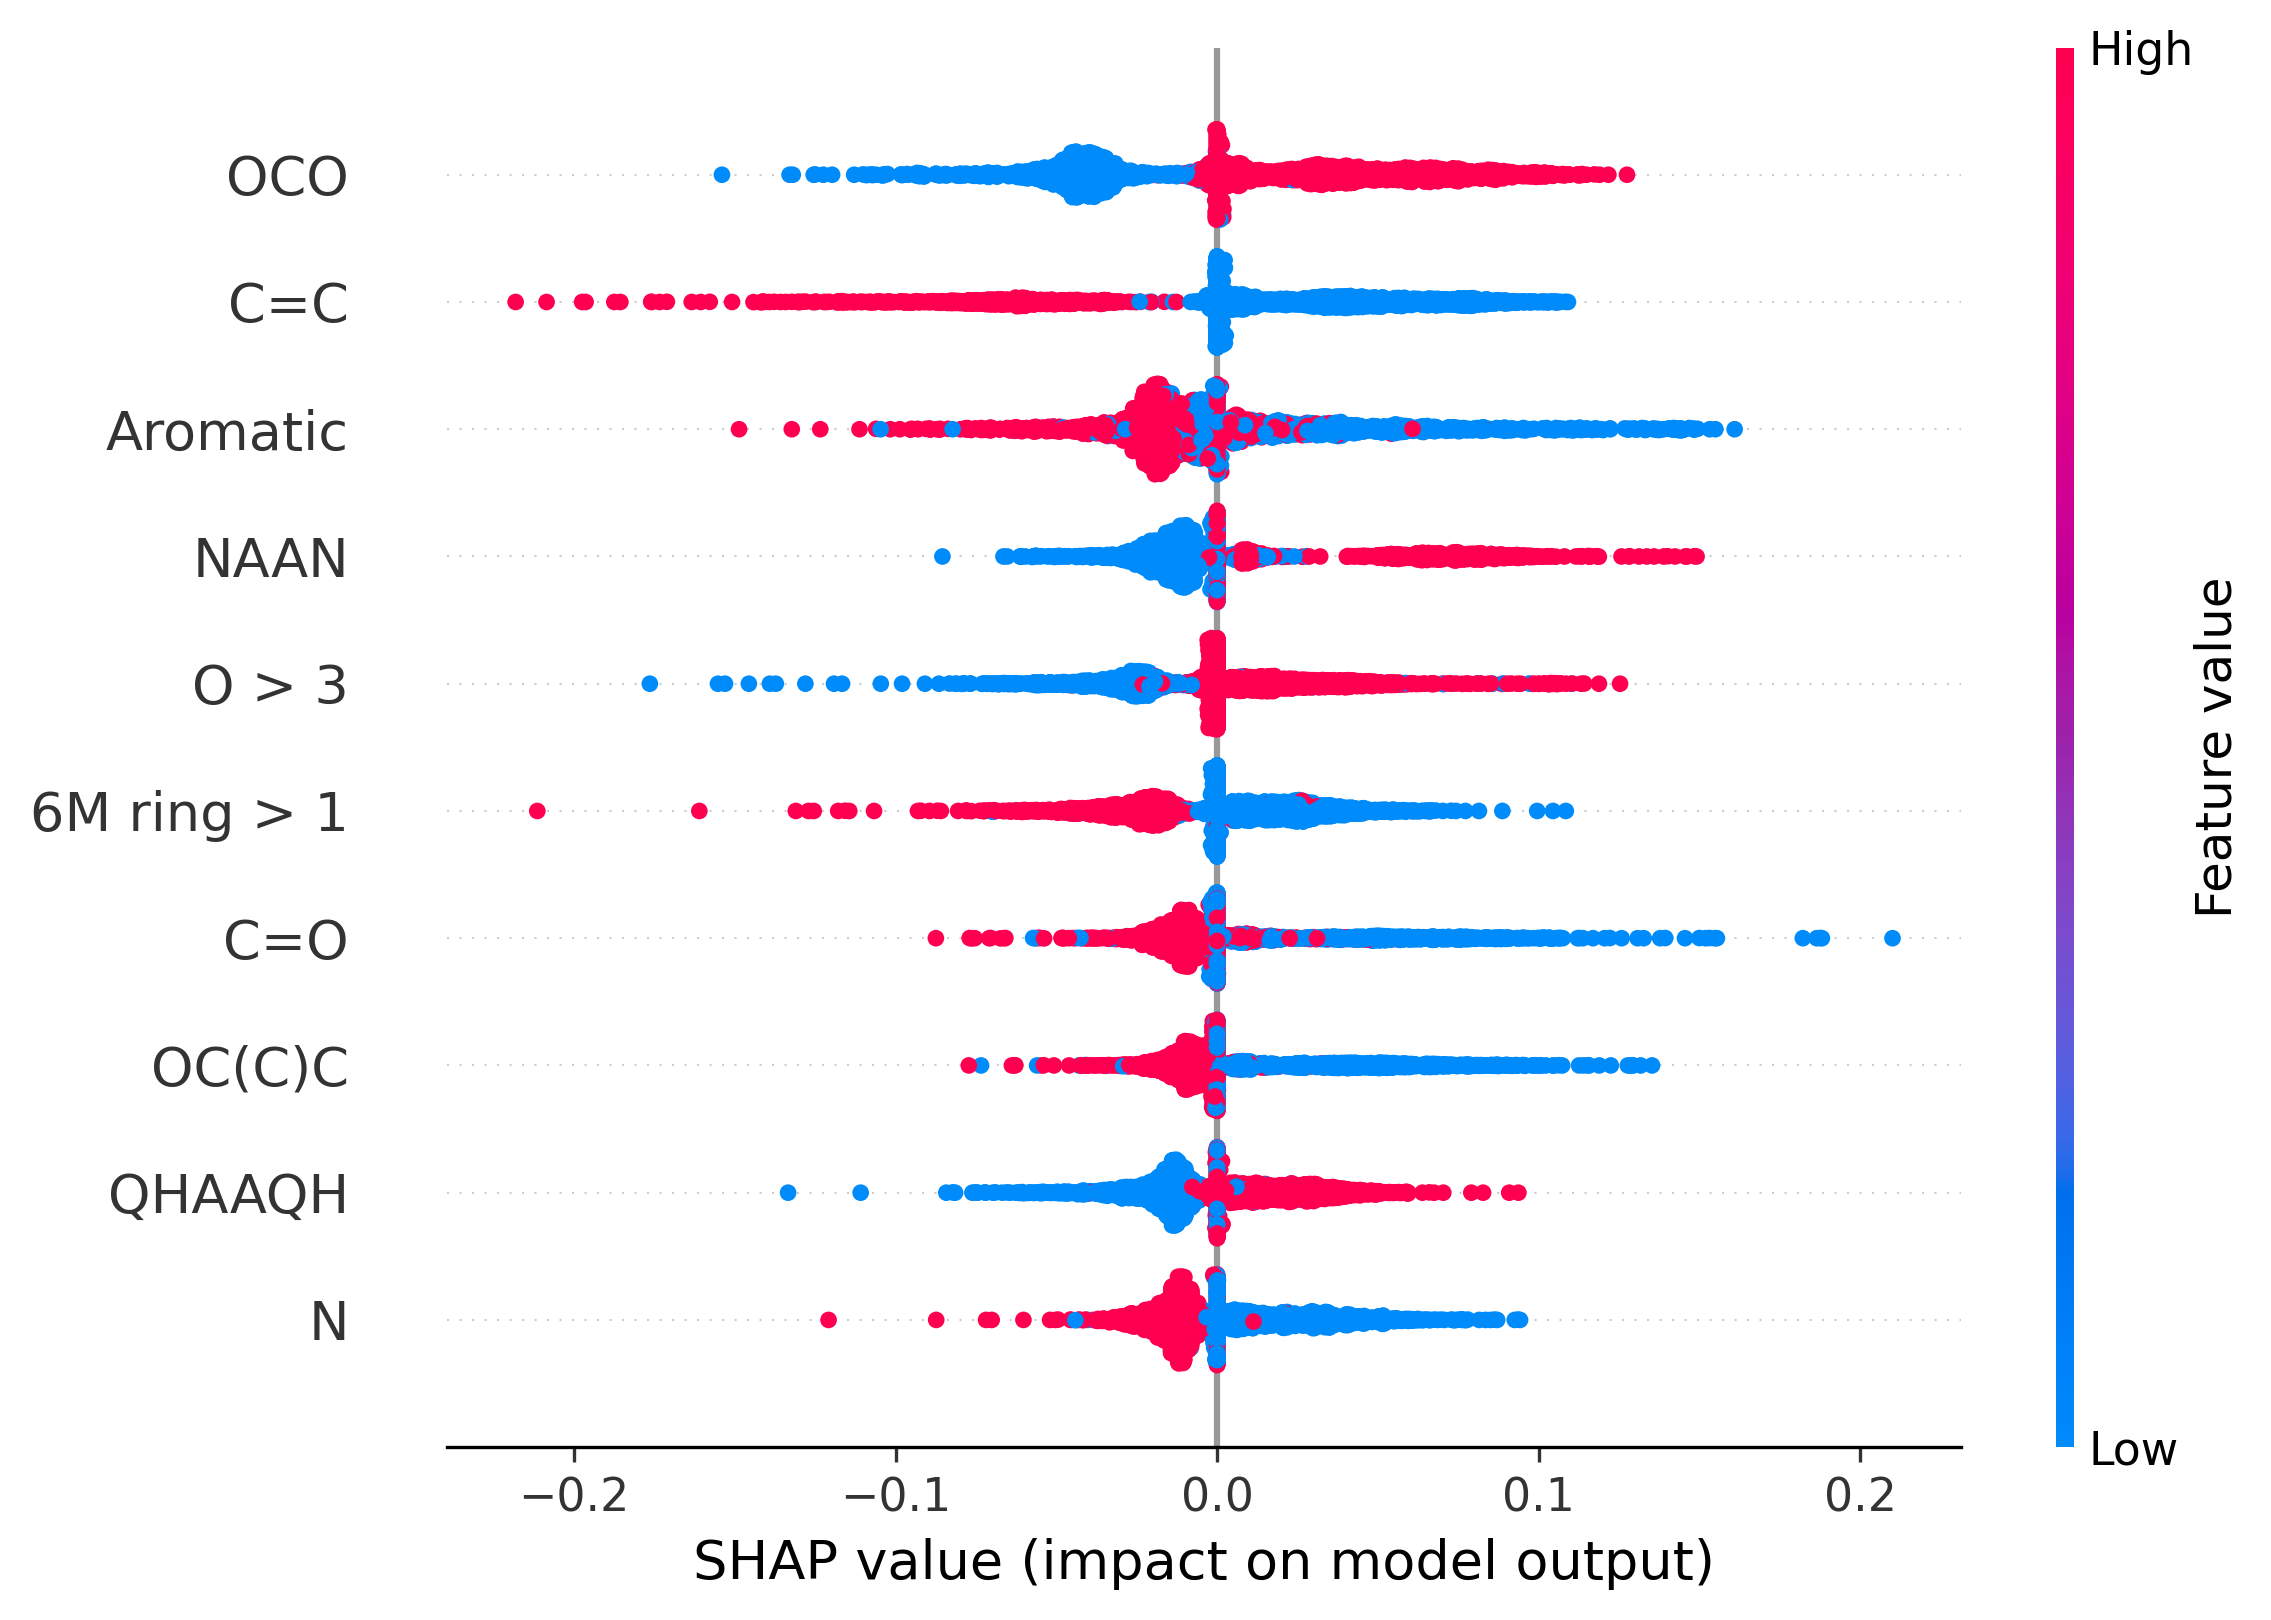

In [100]:
shap.summary_plot(shap_values[1], test_dataset.X, max_display=10, feature_names = result)

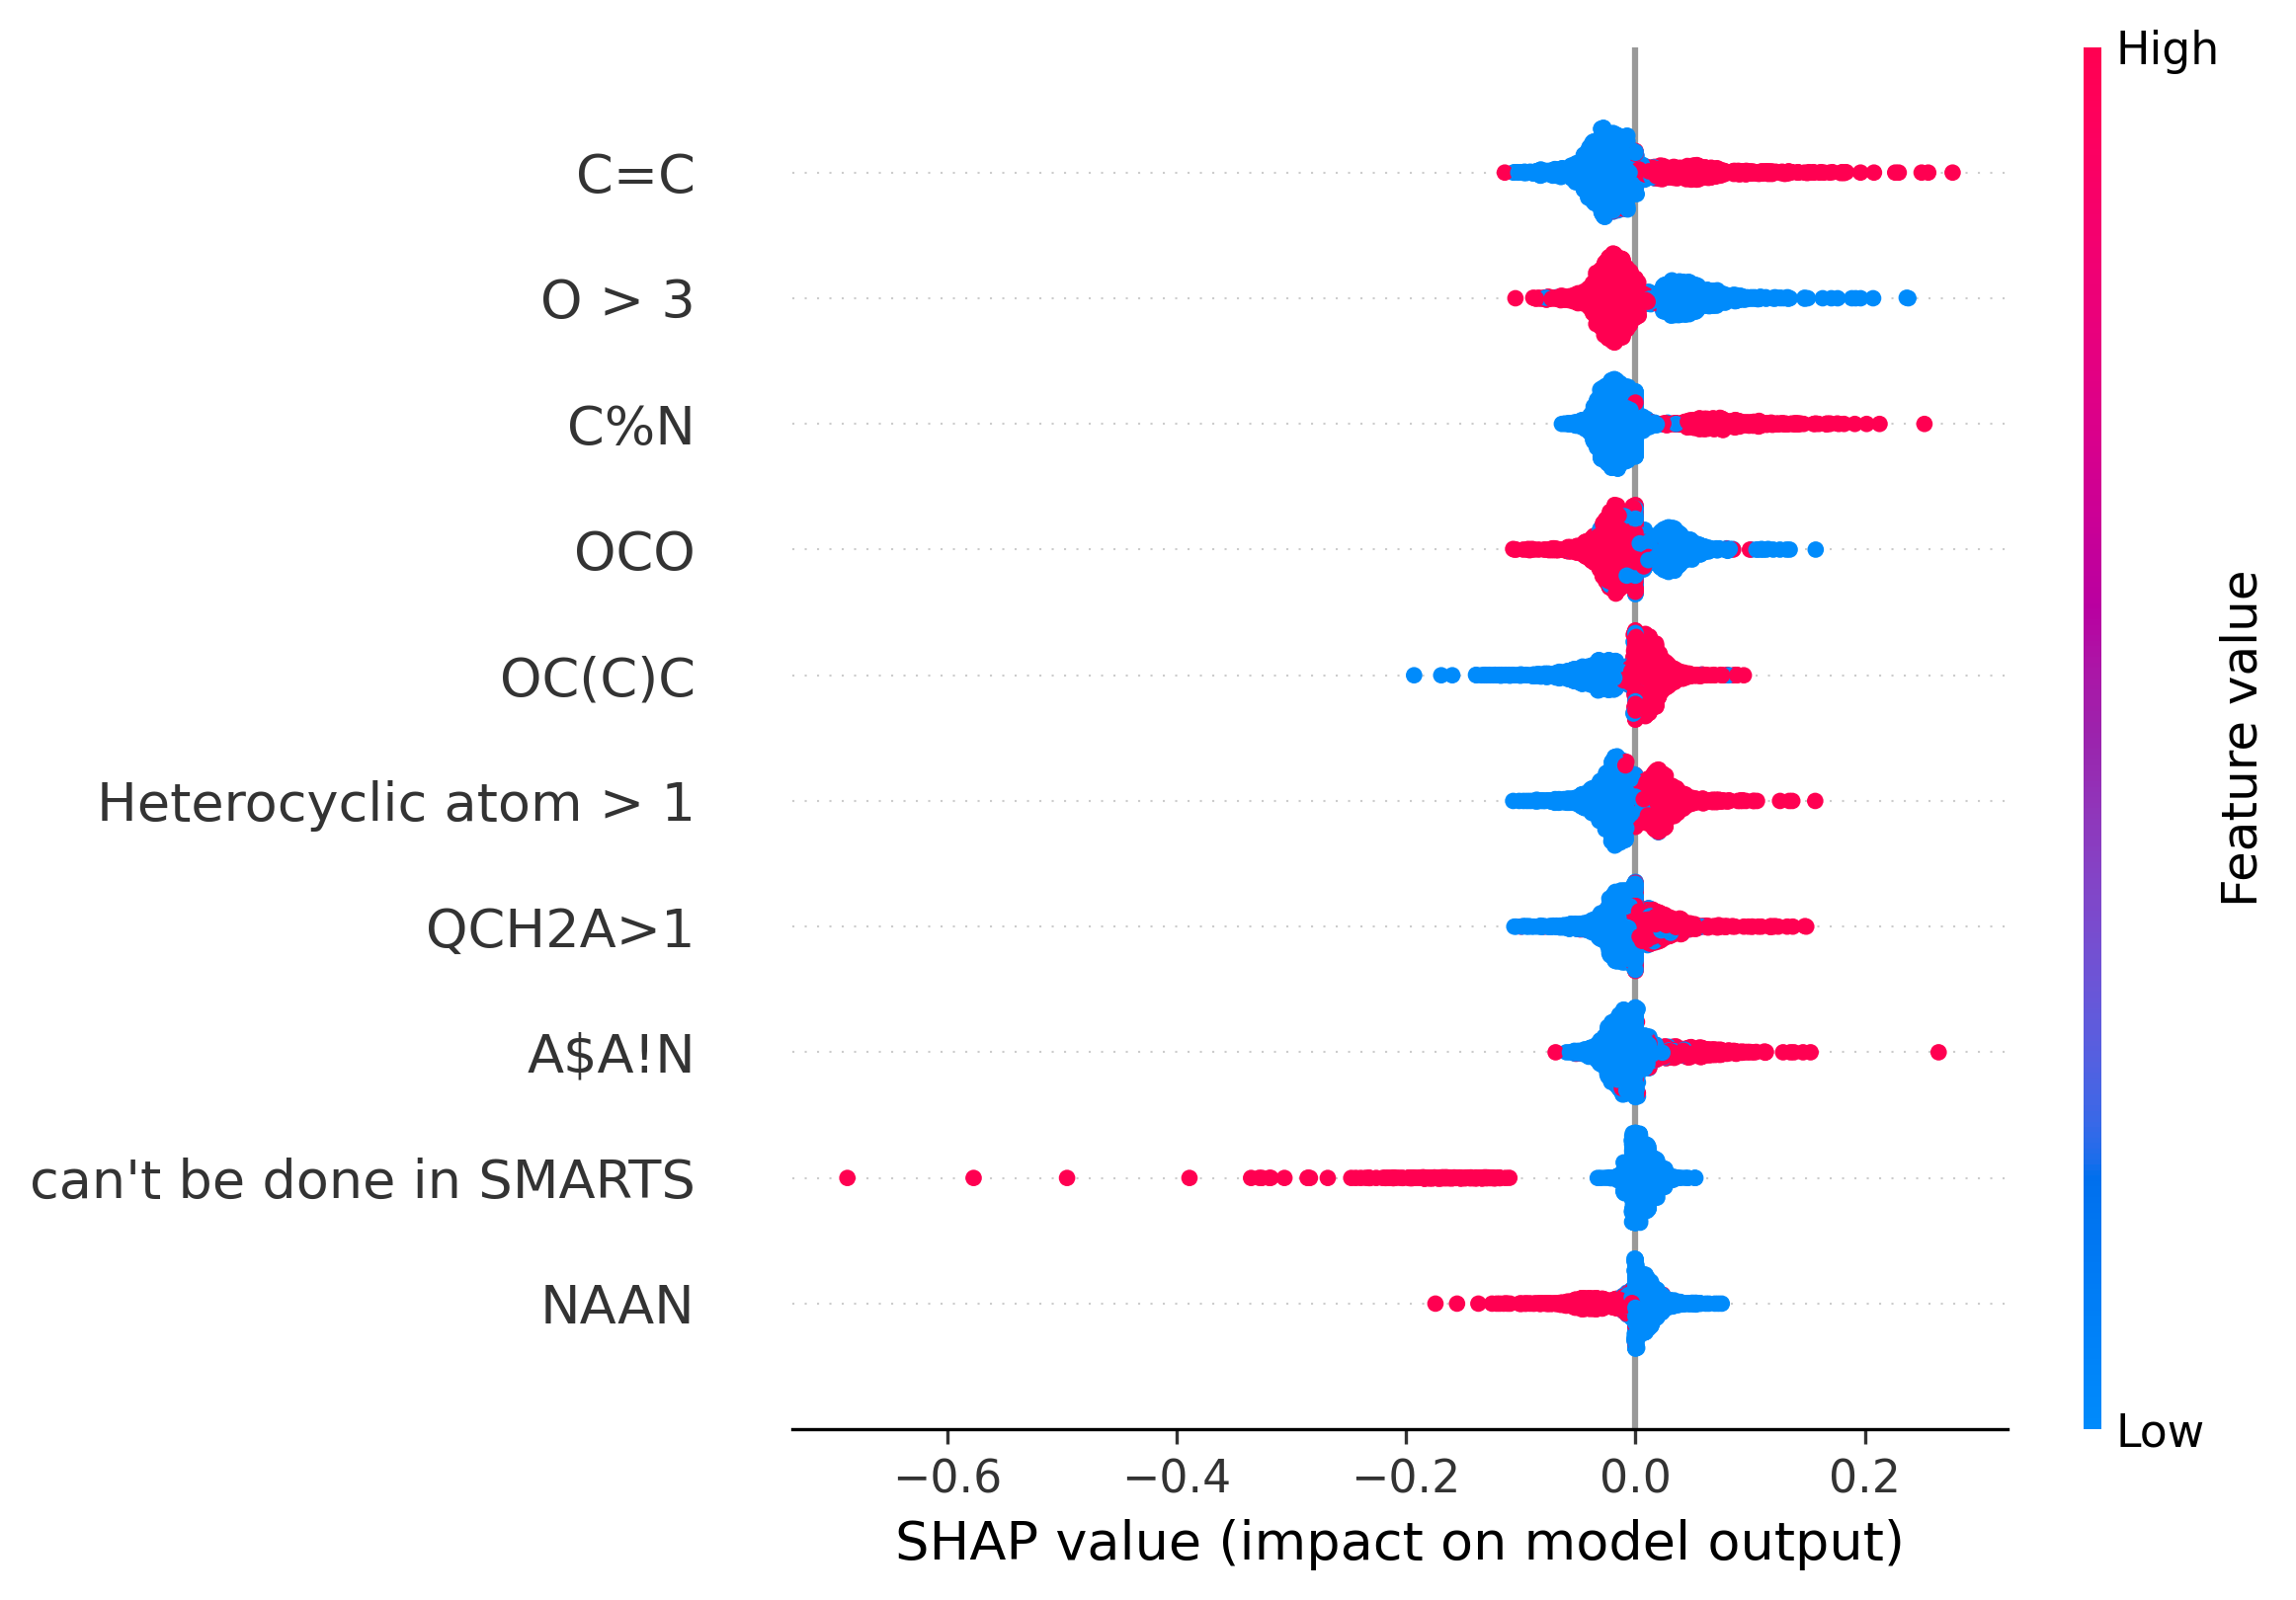

In [101]:
shap.summary_plot(shap_values[2], test_dataset.X, max_display=10, feature_names = result)

In [46]:
shap_values2 = explainer.shap_values(test_dataset.X[0:1])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


In [55]:
shap_values2[0].shape

(1, 134)

In [56]:
test_dataset.X[1:2]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 0]])

In [49]:
shap.force_plot(explainer.expected_value[0], shap_values2[1], test_dataset.X[1:2], feature_names = result)

In [57]:
xgb_maccs_model.predict(test_dataset.X[1:2])

array([[0, 0, 1]])

In [66]:
shap_values2[0]

array([[ 0.00298766,  0.        ,  0.        ,  0.        , -0.00441703,
         0.        ,  0.        ,  0.0017423 ,  0.        ,  0.        ,
         0.0029639 ,  0.        , -0.00132589,  0.        ,  0.00161206,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.00501843,  0.        ,  0.        , -0.00334574, -0.00578965,
        -0.00105392,  0.0034041 ,  0.        , -0.00147053,  0.        ,
        -0.00167975,  0.0017236 ,  0.        ,  0.0028717 , -0.00181904,
        -0.00040142,  0.        ,  0.        ,  0.        , -0.00063172,
        -0.00352773,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.006347  , -0.00076502,  0.        ,  0.        ,
        -0.0033916 ,  0.        , -0.00707282,  0.        ,  0.        ,
        -0.01604271, -0.00714575,  0.        ,  0.        ,  0.00251434,
        -0.00059122,  0.        , -0.00198011,  0.        , -0.00416095,
        -0.00418641, -0.00129479, -0.00166374, -0.0

In [ ]:
from shap.plots import _waterfall
_waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0], test_dataset.X)

Binary

In [32]:
rf_performance = pd.DataFrame(rf_performance_dataset,index=['val','test'])
rf_performance

,F1_score,ACC,Recall,Precision
val,0.945604,0.947746,0.946171,0.945085
test,0.952589,0.953613,0.953206,0.952011


In [39]:
import deepchem as dc
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold

from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix, make_scorer,
    accuracy_score, f1_score, recall_score, precision_score
)

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300


data = pd.read_csv('../../data/BST-binary.csv', encoding='gb2312')

featurizer = dc.feat.MACCSKeysFingerprint()
features = featurizer.featurize(data['SMILES'])
data['Label'] = data['Label'].astype(int)


vt = VarianceThreshold(threshold=0.02)
X_new = vt.fit_transform(features)

dataset = dc.data.NumpyDataset(X_new, data['Label'], ids=data['SMILES'])


splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(
    dataset=dataset, frac_train=0.8, seed=300
)


scoring = {
    'F1_score': make_scorer(f1_score, average='macro'),
    'Accuracy': make_scorer(accuracy_score),
    'Recall': make_scorer(recall_score, average='macro'),
    'Precision': make_scorer(precision_score, average='macro'),
}


param_grid = {
    'n_estimators': [60, 80],    
    'max_depth': [3, 4],            
    'colsample_bytree': [0.4, 0.6],  
    'learning_rate': [0.15],        
}

xgb_model = xgb.XGBClassifier(random_state=42)

gs = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=scoring,
    cv=KFold(n_splits=5, shuffle=True, random_state=300),
    n_jobs=-1,
    refit='F1_score',
    return_train_score=True
)

gs_fit = gs.fit(train_dataset.X, train_dataset.y)

val_F1 = gs.best_score_
val_ACC = gs.cv_results_['mean_test_Accuracy'][gs.best_index_]
val_Recall = gs.cv_results_['mean_test_Recall'][gs.best_index_]
val_Precision = gs.cv_results_['mean_test_Precision'][gs.best_index_]

model = gs_fit.best_estimator_
y_test_pred = model.predict(test_dataset.X)

test_F1 = f1_score(test_dataset.y, y_test_pred, average='macro')
test_ACC = accuracy_score(test_dataset.y, y_test_pred)
test_Recall = recall_score(test_dataset.y, y_test_pred, average='macro')
test_Precision = precision_score(test_dataset.y, y_test_pred, average='macro')


rf_performance_dataset = {
    'F1_score': [val_F1, test_F1],
    'ACC': [val_ACC, test_ACC],
    'Recall': [val_Recall, test_Recall],
    'Precision': [val_Precision, test_Precision],
}

rf_performance = pd.DataFrame(rf_performance_dataset, index=['val', 'test'])
rf_performance


[21:08:04] WARNING: not removing hydrogen atom without neighbors


,F1_score,ACC,Recall,Precision
val,0.922538,0.925894,0.921632,0.923543
test,0.920229,0.922363,0.918652,0.922102


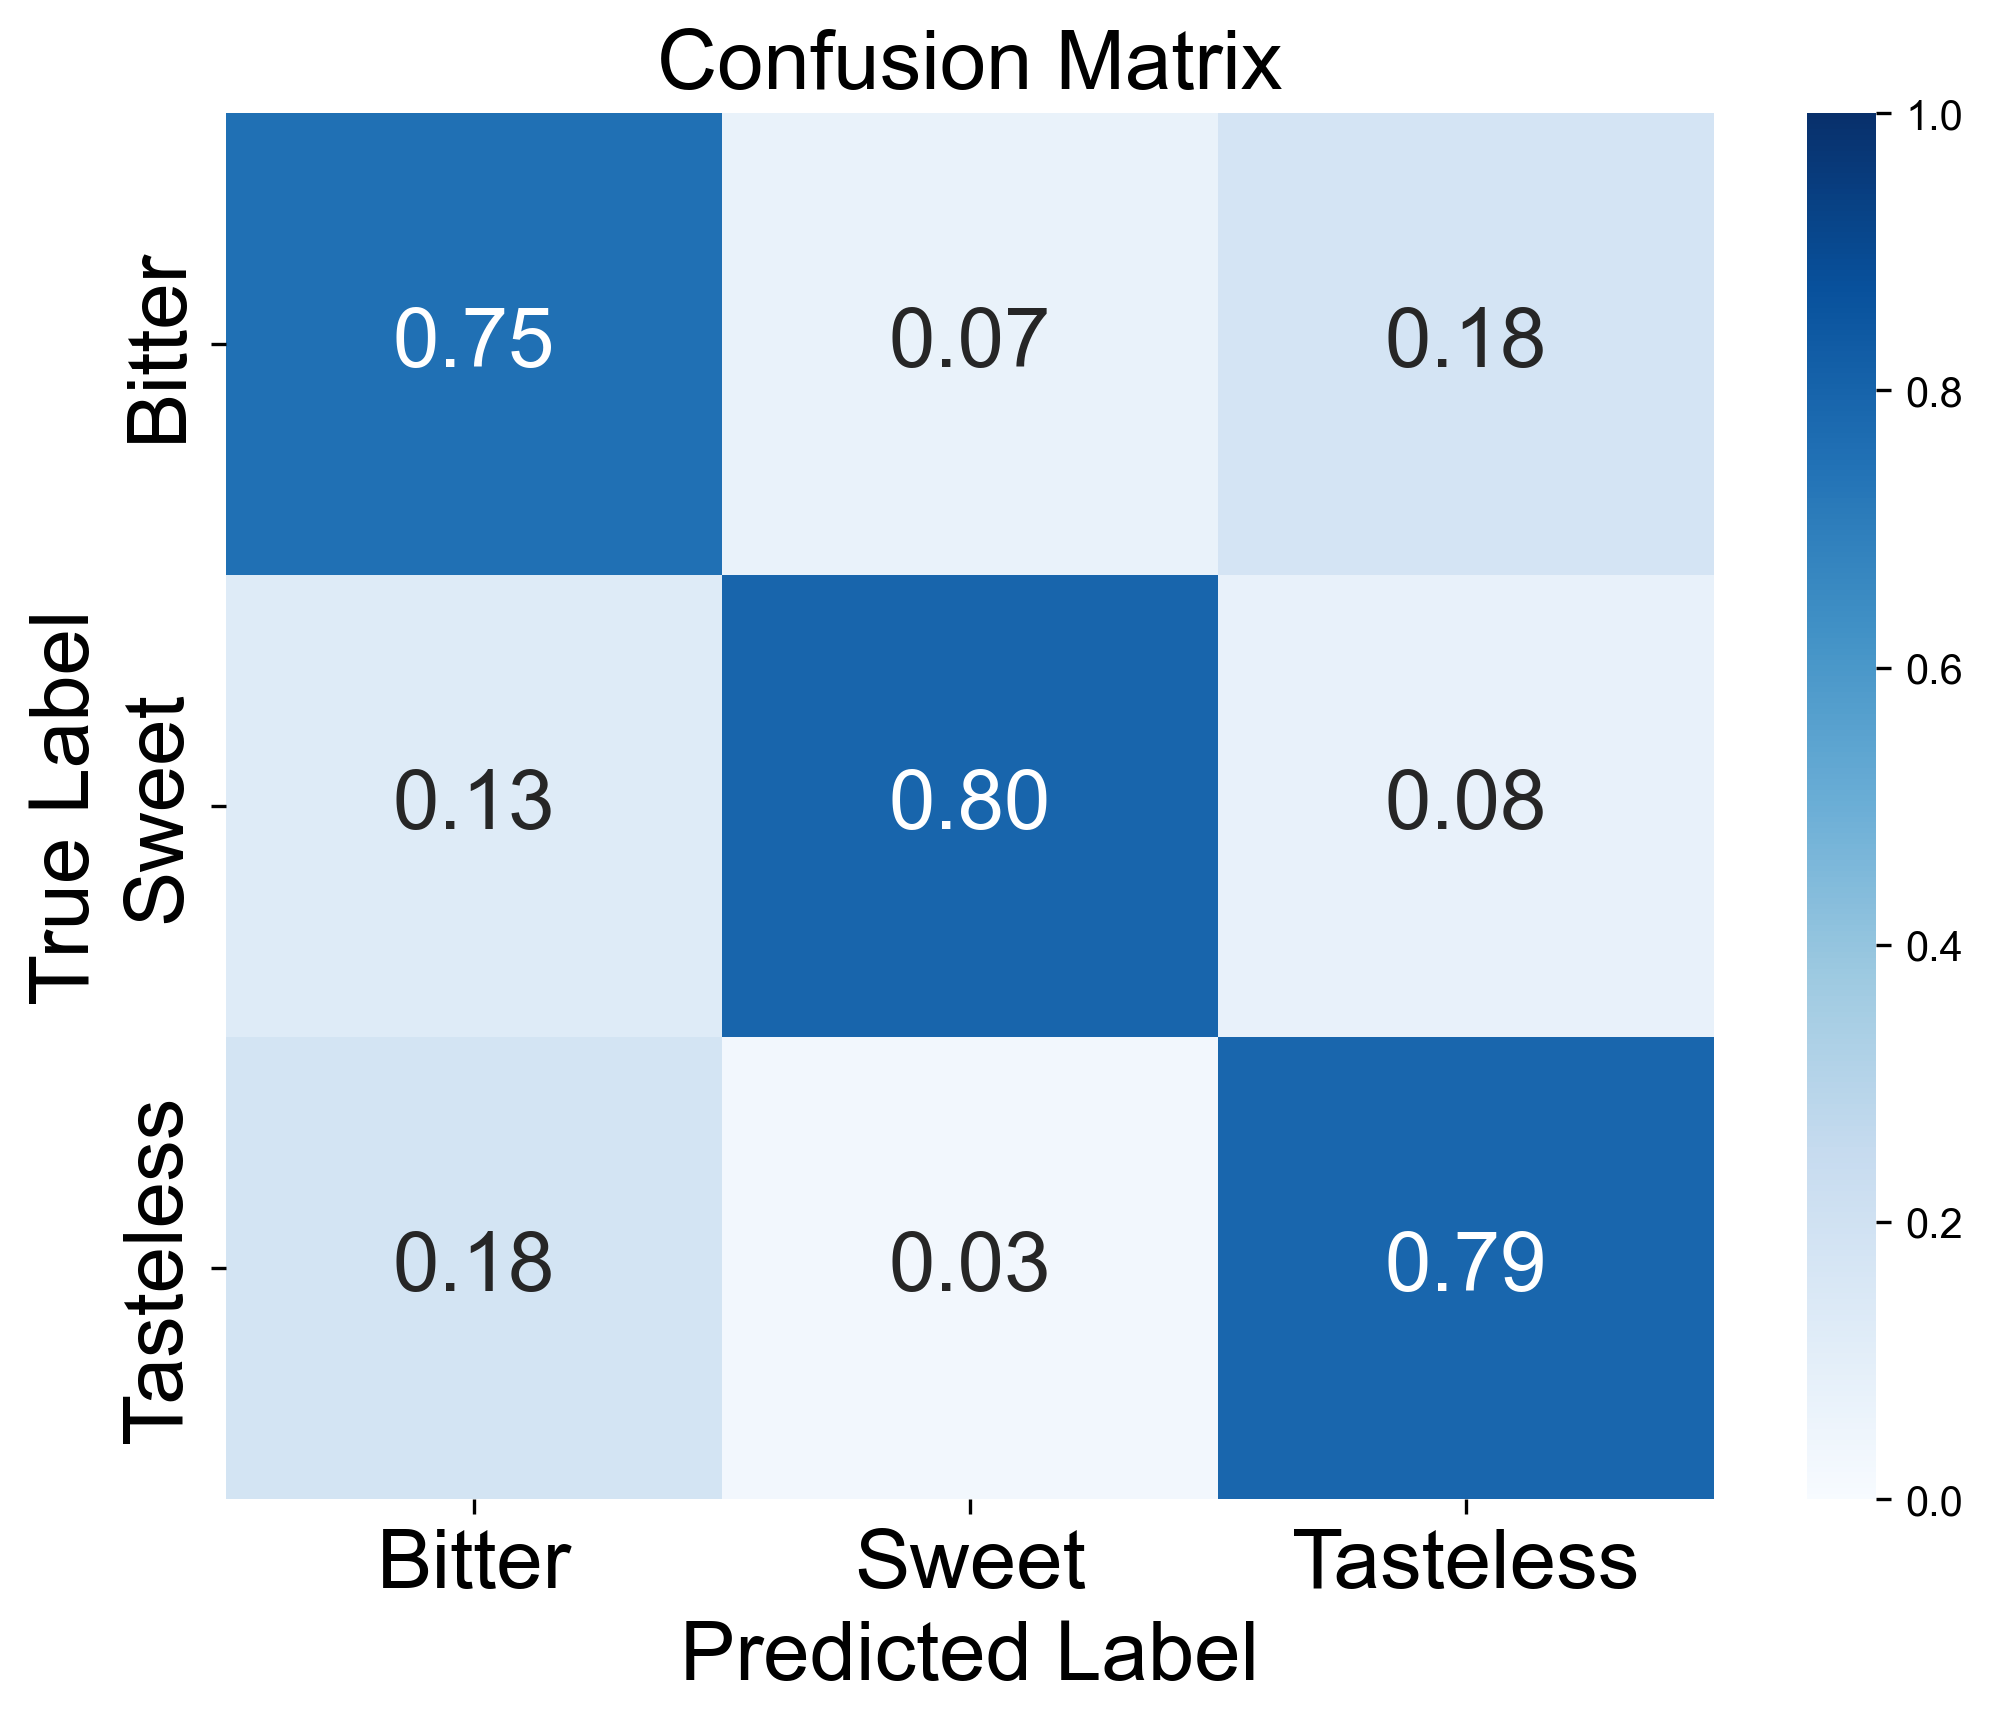

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial']

cm = np.array([[540, 52, 128],
               [53, 330, 32],
               [266, 43, 1162]])

class_names = ['Bitter', 'Sweet', 'Tasteless']

# 按行归一化（每行和为1）
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, 
           annot=True, 
           fmt='.2f',  # 显示两位小数
           cmap='Blues', 
           xticklabels=class_names, 
           yticklabels=class_names,
           vmin=0, vmax=1,
           annot_kws={"size": 20})  # 设置颜色范围

plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()